# Evaluación 1 - Entrenando redes feedforward

**Autores:**

+ Lucas Poblete
+ Jorge Riffo

**Correos Electrónicos:**

+ luc.poblete@duocuc.cl
+ j.riffo@duocuc.cl

**Fecha de Creación:** Abril de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python ...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Carga de datos

In [ ]:
!rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz


In [ ]:
!ls -lh

In [ ]:
import gzip
import shutil
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical
# importación Adam   
from keras.optimizers import Adam
from keras.optimizers import SGD

# Carga de imágenes

In [51]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


### Entradas y Salidas

In [52]:
N = X_train.shape[1]
C = y_train.shape[1]

In [172]:
print(f"N: {N}, C: {C}")

N: 784, C: 10


Se obserba que tenemos 784 entradas, que corresponden a los valores de los pixeles en blanco y negro, y se observan 10 salidas que serias las 10 clases que estan presentes en el dataset.

# Muestra imágenes


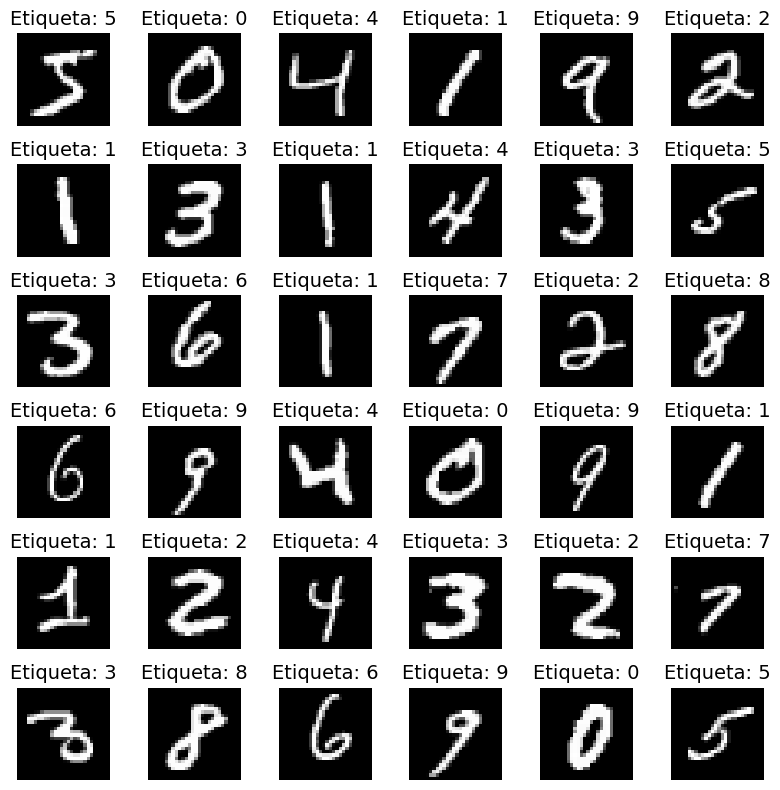

In [53]:
plt.figure(figsize=(8, 8))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Etiqueta: {np.argmax(y_train[i])}', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Desbalance de clases

Clase     Cantidad  Porcentaje
--------------------------------
0         5923      9.87%
1         6742      11.24%
2         5958      9.93%
3         6131      10.22%
4         5842      9.74%
5         5421      9.04%
6         5918      9.86%
7         6265      10.44%
8         5851      9.75%
9         5949      9.92%
--------------------------------
Total     60000     100.00%   



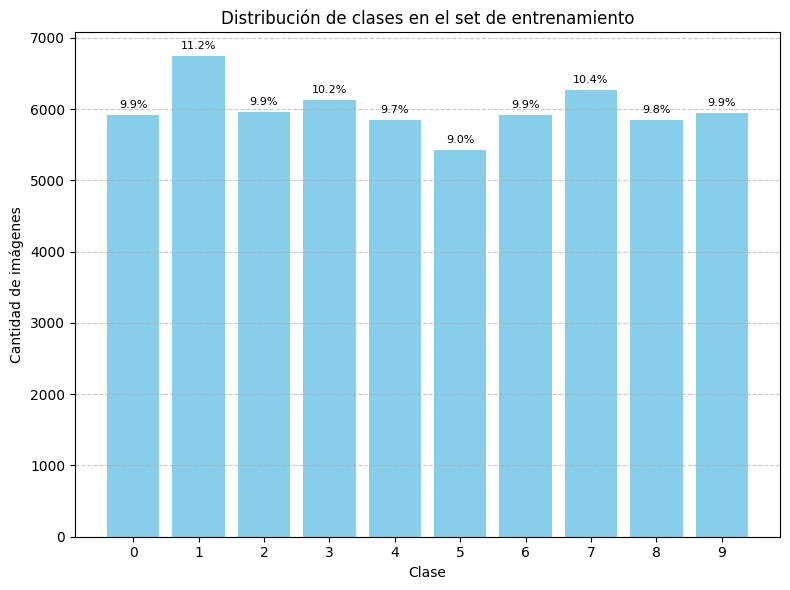

In [54]:
labels = np.argmax(y_train, axis=1)

# Contar cuántas imágenes hay de cada clase (0 al 9)
class_counts = np.bincount(labels)

# Calcular total
total = np.sum(class_counts)

print(f"{'Clase':<10}{'Cantidad':<10}{'Porcentaje':<10}")
print("-" * 32)

# Filas
for i, count in enumerate(class_counts):
    porcentaje = (count / total) * 100
    print(f"{i:<10}{count:<10}{porcentaje:.2f}%")

# Línea final con total
print("-" * 32)
print(f"{'Total':<10}{total:<10}{'100.00%':<10}\n")

# Graficar
plt.figure(figsize=(8, 6))
bars = plt.bar(range(10), class_counts, color='skyblue')
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.title("Distribución de clases en el set de entrenamiento")
plt.xticks(range(10))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir porcentaje sobre las barras
for bar, count in zip(bars, class_counts):
    porcentaje = (count / total) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100,
             f"{porcentaje:.1f}%", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

### Observación
Se observa ligero desbalance de clases en data de entrenamiento.

Clase     Cantidad  Porcentaje
--------------------------------
0         980       9.80%
1         1135      11.35%
2         1032      10.32%
3         1010      10.10%
4         982       9.82%
5         892       8.92%
6         958       9.58%
7         1028      10.28%
8         974       9.74%
9         1009      10.09%
--------------------------------
Total     10000     100.00%   



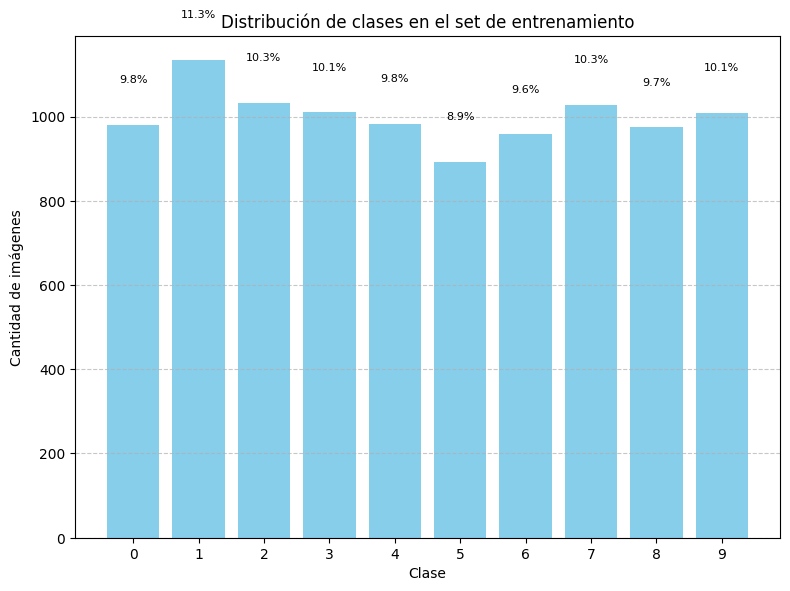

In [173]:
# graficar desbalance de clases data de testeo
labels = np.argmax(y_test, axis=1)

# Contar cuántas imágenes hay de cada clase (0 al 9)
class_counts = np.bincount(labels)

# Calcular total
total = np.sum(class_counts)

print(f"{'Clase':<10}{'Cantidad':<10}{'Porcentaje':<10}")
print("-" * 32)

# Filas
for i, count in enumerate(class_counts):
    porcentaje = (count / total) * 100
    print(f"{i:<10}{count:<10}{porcentaje:.2f}%")

# Línea final con total
print("-" * 32)
print(f"{'Total':<10}{total:<10}{'100.00%':<10}\n")

# Graficar
plt.figure(figsize=(8, 6))
bars = plt.bar(range(10), class_counts, color='skyblue')
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.title("Distribución de clases en el set de entrenamiento")
plt.xticks(range(10))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir porcentaje sobre las barras
for bar, count in zip(bars, class_counts):
    porcentaje = (count / total) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100,
             f"{porcentaje:.1f}%", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

### Observación
Se observa ligero desbalance de clases en la data de testeo, conservando casi identicamente el desbalance que se presenta en la data de entrenamiento.

# Métricas importantes

## Accuracy

Determina el porcentaje de clasificaciones de imagenes correctas del modelo.

- No es muy util en casos de desbalance de clases

Formula


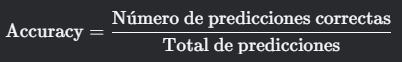

## Precision (Por clase)

Mide la calidad de las predicciones positivas

- De importancia cuando los FP son de importancia en el negocio

Formula

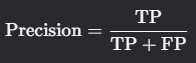

* TP (True Positives): Casos correctamente clasificados en la clase.
* FP (False Positives): Casos de otras clases erroneamente clasificados en esta.

## Recall (Por clase)

Capacidad de detectar una clase
- Crítico cuando los FN son de importancia

Formula

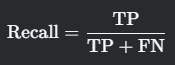

* TP (True Positives): Casos correctamente clasificados en la clase.
* FN (False Negatives): Casos de la clase que fueron erroneamente clasificados en otras.

## F1-score

Media armónica entre precision y Recall
- Util en balance entre FP y FN

Formula

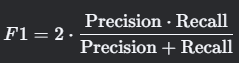

## Confusion Matrix

Muestra los valores reales vs los predichos en una matriz de todas las clases.
- Permite un analisis mas grafico de las predicciondes del modelo

Ejemplo:

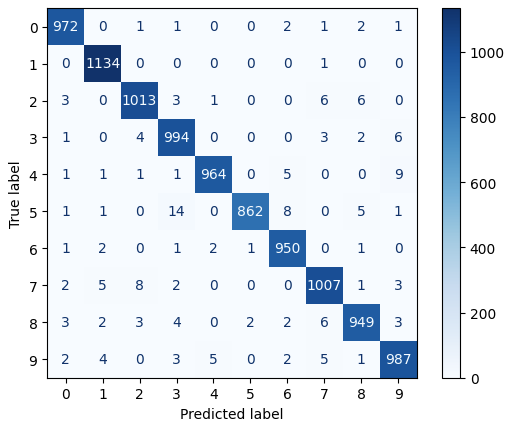

## Elección de métrica para evaluar los distintos modelos de redes neuronales

Se ha elegido en este caso el Accuracy ya que el desbalance de clases no es tan relevante, es una métrica sencilla y mide la performance global del modelo. Siempre teniendo cuidado con mantener este desbalance proporcionalmente cuando se dividan los datos en datos para entrenamiento y testeo.

# Arquitecturas

Para la arquitectura de los modelos con los optimizadores Adam y SGD, se estableció la cantidad de 512 neuronas para la 1era capa, 256 para la 2da capa y 128 para la 3 capa, todo esto con el fin de tener una arquitectura con gran cantidad de neuronas las cuales permitira que la red aprenda patrones mas complejos y con esto obtener una clasificación mas exacta. En base a esta arquitectura se ira experimentado con las funciones de activacion, salidad, perdida, hiperparametros y tecnicas de optimización.

Las funciones de la arquitectura varian desde funciones que se aplican especificamente en casos donde hay mas de una clase y tambien se implementó funciones las cuales solo funcionan con solo una clase, se tiene en conocimiento y tambien esta dentro de lo esperado que estas funciones las cuales solo se aplican en proyectos con una sola clase, tenga un rendimiento realmente bajo igualmente todo es en base a la experimentación, con esta experimentacion se espera poder obtener en evidencia los rendimientos que se puedan obtener de los distintos modelos, esto en base a la metrica seleccionada.

## Funciones (crear redes customizadas y graficos)

In [55]:
def crear_red_neuronal(
    N,                          # Dimension de entrada
    C,                          # Neuronas de salida (clases)
    activaciones,               # Lista de funciones de activación por capa (ej: ['relu', 'relu', 'relu', 'softmax'])
    neuronas=[512, 256, 128],  # Neuronas por capa oculta (por defecto: [1024, 512, 256])
    dropout=None,               # None o lista de tasas de dropout por capa (ej: [0.2, 0.3, 0.1])
    nombre="Red_Personalizada"  # Nombre de la red
):
    """
    Crea una red neuronal con:
    - Activaciones personalizadas por capa.
    - Dropout opcional en capas ocultas.
    - Nombre personalizado.
    """
    red = keras.Sequential(name=nombre)
    red.add(keras.layers.Input(shape=(N,), name='entrada'))

    for i, (n_neuronas, activacion) in enumerate(zip(neuronas, activaciones[:-1])):
        red.add(keras.layers.Dense(n_neuronas, activation=activacion))
        if dropout and i < len(dropout):  # Añadir dropout si se especifica
            red.add(keras.layers.Dropout(dropout[i]))

    # Capa de salida (activación final)
    red.add(keras.layers.Dense(C, activation=activaciones[-1]))

    return red

In [56]:
def plot_history(hist, name_model):

  # Crear figura con dos subplots horizontales
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  fig.suptitle(f'Evolución del Entrenamiento - {name_model}', fontweight="bold", fontsize=18)

  # --- Pérdida ---
  axs[0].plot(hist.history['loss'], label='Training Loss')
  axs[0].plot(hist.history['val_loss'], label='Validation Loss')
  axs[0].set_title('Pérdida', fontweight="bold", fontsize=16)
  axs[0].set_xlabel('Época', fontweight="bold", fontsize=14)
  axs[0].set_ylabel('Loss', fontweight="bold", fontsize=14)
  axs[0].legend()
  axs[0].grid(True)

  # --- Precisión ---
  axs[1].plot(hist.history['accuracy'], label='Training Accuracy')
  axs[1].plot(hist.history['val_accuracy'], label='Validation Accuracy')
  axs[1].set_title('% Acierto', fontweight="bold", fontsize=16)
  axs[1].set_xlabel('Época', fontweight="bold", fontsize=14)
  axs[1].set_ylabel('Accuracy', fontweight="bold", fontsize=14)
  axs[1].legend()
  axs[1].grid(True)

  plt.tight_layout()
  plt.show()

## Activadores

Los activadores permiten a las redes neuronales agregar componentes no lineales

# Optimizador 1: Adam

## Experimentación 1:  Cambios  en epocas y batch size

- Epocas: Número de iteraciones de entrenamiento, o el número de veces que el modelo entrena utilizando el conjunto de datos de entrenamiento para ello.
- Batch size: Número de muestras de entrenamiento que se procesan antes de actualizar los pesos del modelo.

In [120]:
neuronas=[512, 256, 128]
activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V1"

## Crear red
red_adamv1 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=None,
    nombre=nombre_red
)

In [58]:
## Compilacion de la red
red_adamv1.compile(
    loss= 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Resumen de la red construida
red_adamv1.summary()

Model: "Red_Neuronal_Adam_V1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento con 30 epocas y batch size 20

Primero escojeremos esta configuración simple, con 30 epocas y un batch size pequeño para observar el comportamiento del modelo.

In [59]:
hist_redadamv1_1 = red_adamv1.fit(
        X_train, y_train,
        epochs=30,
        batch_size=20,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9031 - loss: 0.3110 - val_accuracy: 0.9671 - val_loss: 0.1020
Epoch 2/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9710 - loss: 0.0948 - val_accuracy: 0.9742 - val_loss: 0.0870
Epoch 3/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9800 - loss: 0.0627 - val_accuracy: 0.9671 - val_loss: 0.1235
Epoch 4/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9845 - loss: 0.0489 - val_accuracy: 0.9761 - val_loss: 0.0857
Epoch 5/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9880 - loss: 0.0372 - val_accuracy: 0.9704 - val_loss: 0.1163
Epoch 6/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9891 - loss: 0.0359 - val_accuracy: 0.9802 - val_loss: 0.0793
Epoch 7/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9914 - loss: 0.0280 - val_accuracy: 0.9772 - val_loss: 0.0826
Epoch 8/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9919 - loss: 0

In [121]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds = []
history_reds.append({
    'epocas': 30,
    'batch_size': 20,
    'learning_rate': 0.001,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': None,
    'train_loss': hist_redadamv1_1.history['loss'][-1],
    'train_accuracy': hist_redadamv1_1.history['accuracy'][-1],
    'test_loss': hist_redadamv1_1.history['val_loss'][-1],
    'test_accuracy': hist_redadamv1_1.history['val_accuracy'][-1]
})

columnas = []
columnas.append(nombre_red)

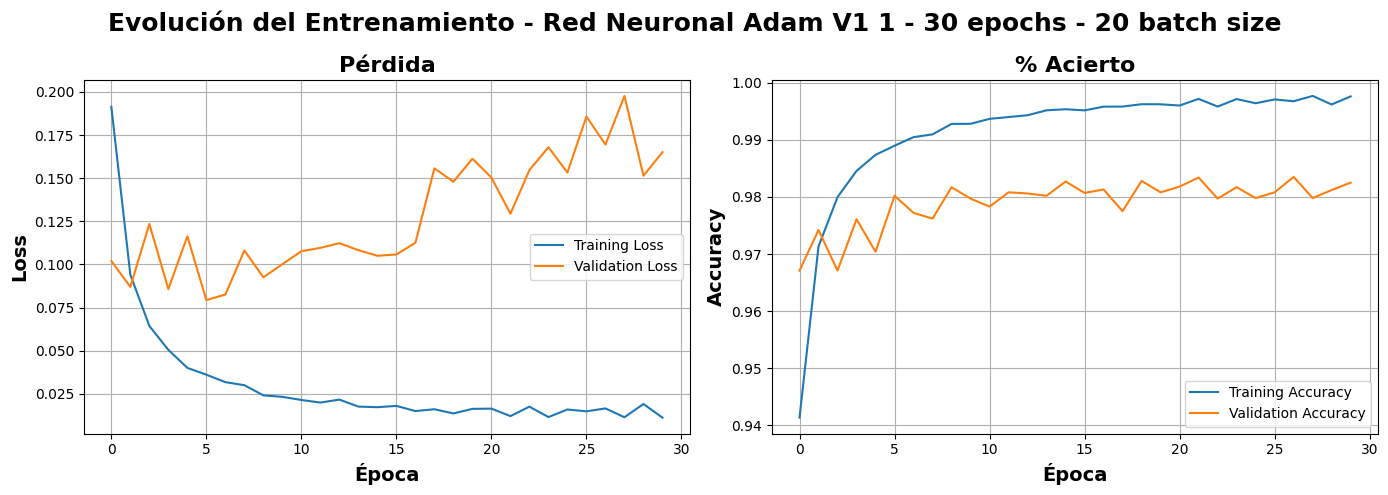

In [61]:
plot_history(hist_redadamv1_1, name_model="Red Neuronal Adam V1 1 - 30 epochs - 20 batch size")

### Entrenamiento con 30 epocas y batch size 60

Aumentaremos el batch size para observar si el rendimiento del modelo disminuye mucho con un aumento del batch size al doble.

In [ ]:
neuronas=[512, 256, 128]

activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V1_2"

## Crear red
red_adamv1_2 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=None,
    nombre=nombre_red
)

red_adamv1_2.compile(
    loss= 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


## Entrenamiento de la red
hist_redadamv1_2 = red_adamv1_2.fit(
        X_train, y_train,
        epochs=30,
        batch_size=60,
        validation_data=(X_test, y_test),
        verbose=1
    )

KeyboardInterrupt: 

In [125]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds.append({
    'epocas': 30,
    'batch_size': 60,
    'learning_rate': 0.001,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': None,
    'train_loss': hist_redadamv1_2.history['loss'][-1],
    'train_accuracy': hist_redadamv1_2.history['accuracy'][-1],
    'test_loss': hist_redadamv1_2.history['val_loss'][-1],
    'test_accuracy': hist_redadamv1_2.history['val_accuracy'][-1]
})

columnas.append(nombre_red)

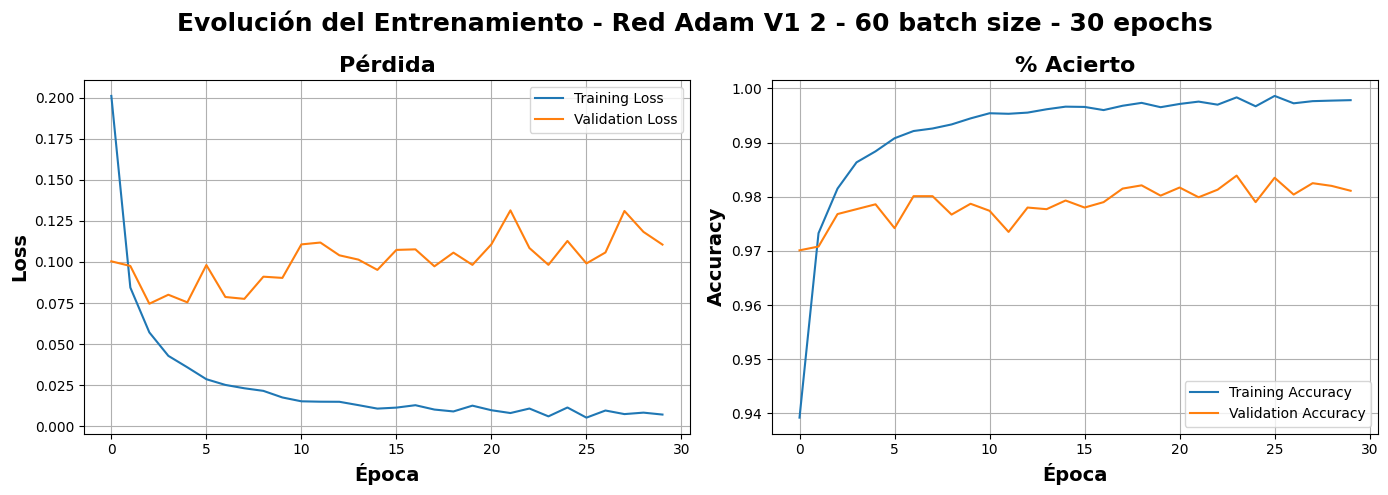

In [64]:
plot_history(hist_redadamv1_2, name_model="Red Adam V1 2 - 60 batch size - 30 epochs")

### Entrenamiento con 20 epocas y batch size 120

Como no vemos grandes cambios, disminuiremos las epocas y aumentaremos al doble nuevamente el batch size y observaremos como se comporta el modelo.

In [65]:
neuronas=[512, 256, 128]

activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V1_3"

## Descripción red
red_adamv1_3_descrip = "Optimizer: Adam \n Activation: Relu + Softmax \n Drop out: No \n Loss: Categorical crossentropy"

## Crear red
red_adamv1_3 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=None,
    nombre=nombre_red
)

red_adamv1_3.compile(
    loss= 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Entrenamiento de la red
hist_redadamv1_3 = red_adamv1_3.fit(
        X_train, y_train,
        epochs=20,
        batch_size=120,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8737 - loss: 0.4302 - val_accuracy: 0.9652 - val_loss: 0.1118
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9730 - loss: 0.0899 - val_accuracy: 0.9754 - val_loss: 0.0767
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9838 - loss: 0.0518 - val_accuracy: 0.9739 - val_loss: 0.0850
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9886 - loss: 0.0365 - val_accuracy: 0.9739 - val_loss: 0.0872
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9904 - loss: 0.0293 - val_accuracy: 0.9766 - val_loss: 0.0778
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9912 - loss: 0.0258 - val_accuracy: 0.9749 - val_loss: 0.0924
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9926 - loss: 0.0218 - val_accuracy: 0.9779 - val_loss: 0.0814
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9938 - loss: 0.0187 - val_accuracy: 0.

In [127]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.001,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': None,
    'train_loss': hist_redadamv1_3.history['loss'][-1],
    'train_accuracy': hist_redadamv1_3.history['accuracy'][-1],
    'test_loss': hist_redadamv1_3.history['val_loss'][-1],
    'test_accuracy': hist_redadamv1_3.history['val_accuracy'][-1]
})

columnas.append(nombre_red)

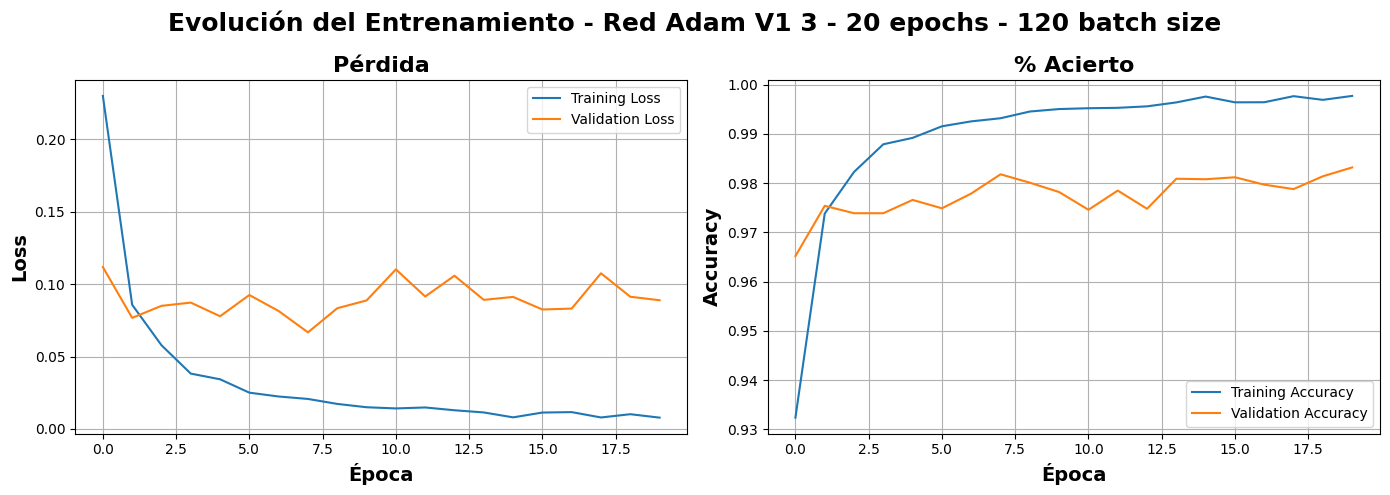

In [67]:
plot_history(hist_redadamv1_3, name_model='Red Adam V1 3 - 20 epochs - 120 batch size')

## Resultados de experimentación 1: Cambios en batch size y epocas

Para el Optimizador Adam, la configuración de arquitectura mas conveniente es la entrenada con 20 epocas y un batch size de 120, ya que en las demas requieren de mas recursos y se obtienen resultados muy similares.

## Experimentación 2:  Cambios en Learning rate

El learning rate define cuanto se actuyalizan los pesos de la red en cada iteración

- Si es muy alto, el modelo puede diverger u oscilar.
- Si es muy bajo el modelo puede aprender muy lento o se puede estancar en minimos locales.

### Red Neuronal con optimizador Adam con learning rate = 0.1

Observaremos el comportamiento del modelo con un learning rate mayor al que se utiliza por default en keras (learning rate por default 0.001).

In [128]:
neuronas=[512, 256, 128]

activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V2_1"

## Crear red
red_adamv2_1 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=None,
    nombre=nombre_red
)

In [69]:
## Compilacion de la red para resetear pesos
red_adamv2_1.compile(
    loss= 'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.1),
    metrics=['accuracy']
)

## Entrenamiento de la red
hist_redadamv2_1 = red_adamv2_1.fit(
        X_train, y_train,
        epochs=20,
        batch_size=120,
        validation_data=(X_test, y_test),
        verbose=1
    )

## Descripción red
red_adamv2_1_descrip = "Optimizer: Adam \n Activation: Relu + Softmax \n Drop out: No \n Loss: Categorical crossentropy \n Batch size: 120 \n Epochs: 50 \n Learnind rate: 0.1"

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1136 - loss: 22.0272 - val_accuracy: 0.1135 - val_loss: 2.3044
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1021 - loss: 2.3212 - val_accuracy: 0.1028 - val_loss: 2.3102
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1028 - loss: 2.3084 - val_accuracy: 0.0958 - val_loss: 2.3127
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1048 - loss: 2.3084 - val_accuracy: 0.1010 - val_loss: 2.3094
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1053 - loss: 2.3069 - val_accuracy: 0.1009 - val_loss: 2.3132
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1029 - loss: 2.3100 - val_accuracy: 0.1009 - val_loss: 2.3085
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1020 - loss: 2.3080 - val_accuracy: 0.1010 - val_loss: 2.3049
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1015 - loss: 2.3076 - val_accuracy: 0

In [129]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.1,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': None,
    'train_loss': hist_redadamv2_1.history['loss'][-1],
    'train_accuracy': hist_redadamv2_1.history['accuracy'][-1],
    'test_loss': hist_redadamv2_1.history['val_loss'][-1],
    'test_accuracy': hist_redadamv2_1.history['val_accuracy'][-1]
})

columnas.append(nombre_red)

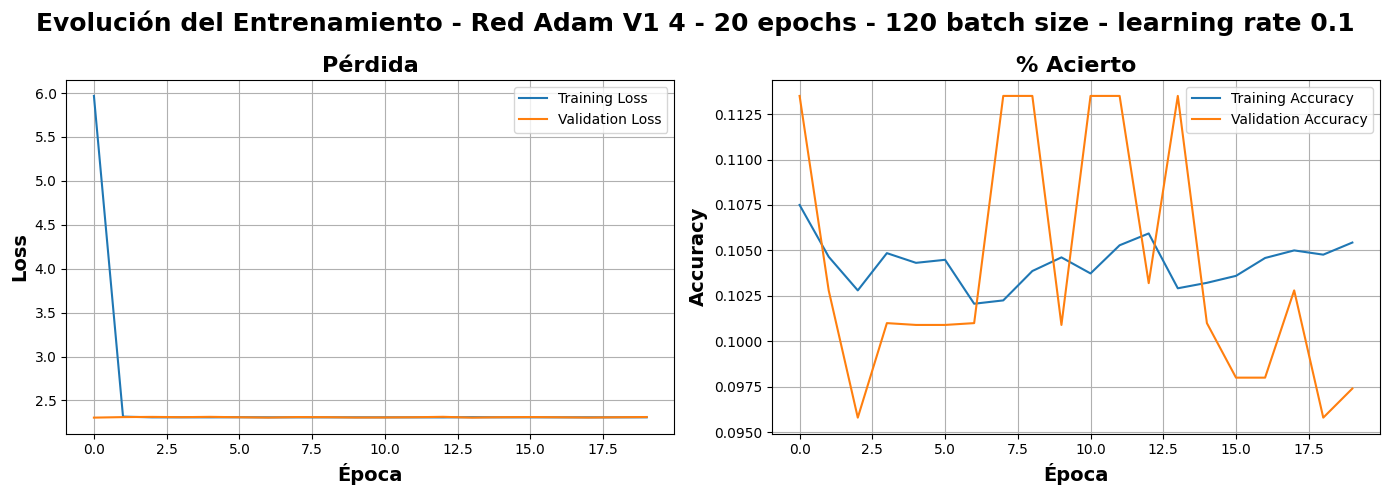

In [71]:
plot_history(hist_redadamv2_1, name_model='Red Adam V1 4 - 20 epochs - 120 batch size - learning rate 0.1')

### Red Neuronal con optimizador Adam con learning rate = 0.01

Como observamos un rendimiento deficiente con un valor alto en learning rate, nos acercaremos al valor por defecto de learning rate para ver como se comporta esta vez el modelo. Aumentaremos el valor a 0.01.

In [130]:
neuronas=[512, 256, 128]

activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V2_2"

## Crear red
red_adamv2_2 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=None,
    nombre=nombre_red
)

In [73]:
## Compilacion de la red para resetear pesos
red_adamv2_2.compile(
    loss= 'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

## Entrenamiento de la red
hist_red_adamv2_2 = red_adamv2_2.fit(
        X_train, y_train,
        epochs=20,
        batch_size=120,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8582 - loss: 0.4864 - val_accuracy: 0.9555 - val_loss: 0.1534
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9599 - loss: 0.1411 - val_accuracy: 0.9619 - val_loss: 0.1498
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9693 - loss: 0.1100 - val_accuracy: 0.9686 - val_loss: 0.1175
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9712 - loss: 0.1080 - val_accuracy: 0.9683 - val_loss: 0.1326
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9766 - loss: 0.0869 - val_accuracy: 0.9700 - val_loss: 0.1232
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9788 - loss: 0.0777 - val_accuracy: 0.9693 - val_loss: 0.1351
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9779 - loss: 0.0858 - val_accuracy: 0.9671 - val_loss: 0.1411
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9825 - loss: 0.0689 - val_accuracy: 0.

In [131]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.01,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': None,
    'train_loss': hist_red_adamv2_2.history['loss'][-1],
    'train_accuracy': hist_red_adamv2_2.history['accuracy'][-1],
    'test_loss': hist_red_adamv2_2.history['val_loss'][-1],
    'test_accuracy': hist_red_adamv2_2.history['val_accuracy'][-1]
})

columnas.append(nombre_red)

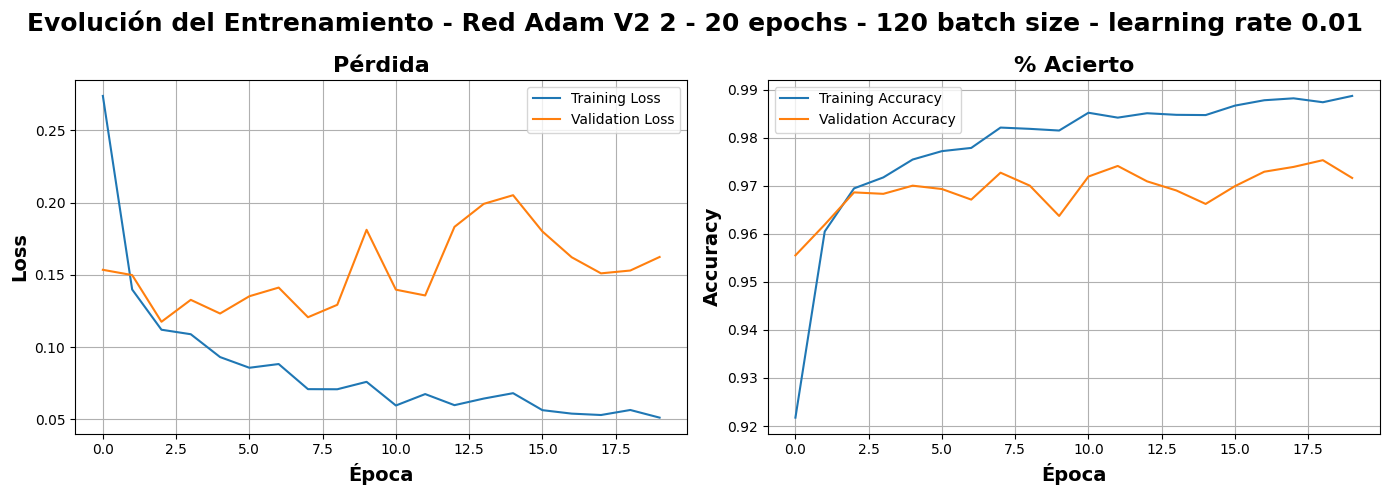

In [75]:
plot_history(hist_red_adamv2_2, name_model='Red Adam V2 2 - 20 epochs - 120 batch size - learning rate 0.01')

### Red Neuronal con optimizador Adam con learning rate = 0.001 (Valor por default)

In [ ]:
nombre_red = "Red_Neuronal_Adam_V2_3"

# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy de hist_redadamv1_3
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.001,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': None,
    'train_loss': hist_redadamv1_3.history['loss'][-1],
    'train_accuracy': hist_redadamv1_3.history['accuracy'][-1],
    'test_loss': hist_redadamv1_3.history['val_loss'][-1],
    'test_accuracy': hist_redadamv1_3.history['val_accuracy'][-1]
})

columnas.append(nombre_red)


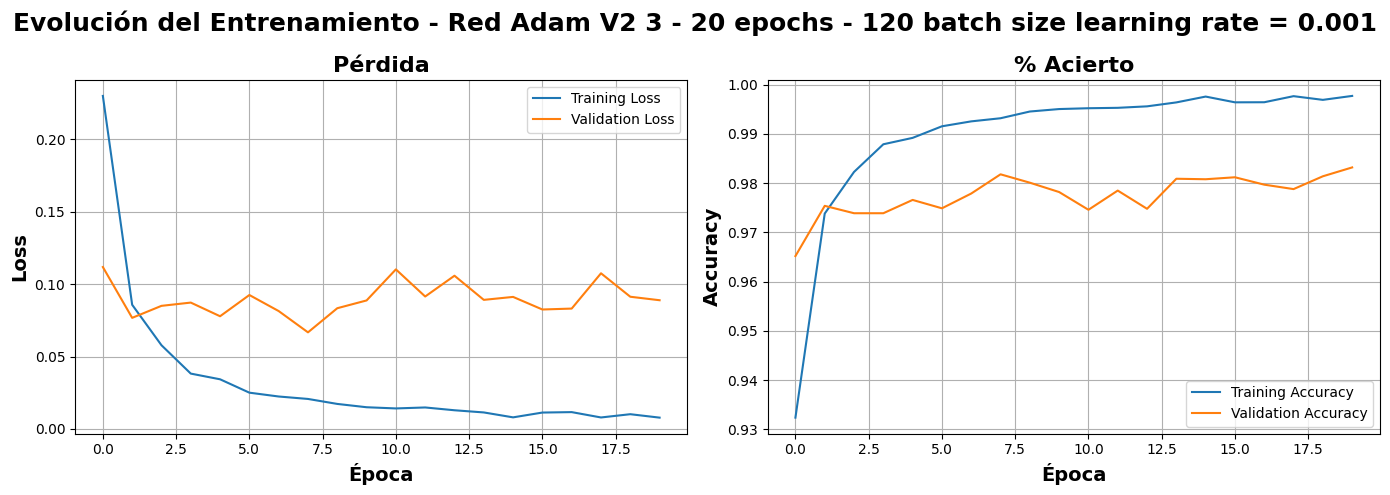

In [77]:
plot_history(hist_redadamv1_3, name_model='Red Adam V2 3 - 20 epochs - 120 batch size learning rate = 0.001')

In [149]:
neuronas=[512, 256, 128]

activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V2_4"

## Crear red
red_adamv2_4 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=None,
    nombre=nombre_red
)

In [150]:
## Compilacion de la red para resetear pesos
red_adamv2_4.compile(
    loss= 'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

## Entrenamiento de la red
hist_red_adamv2_4 = red_adamv2_4.fit(
        X_train, y_train,
        epochs=20,
        batch_size=120,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7531 - loss: 0.9923 - val_accuracy: 0.9351 - val_loss: 0.2221
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9408 - loss: 0.2074 - val_accuracy: 0.9543 - val_loss: 0.1574
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9565 - loss: 0.1493 - val_accuracy: 0.9600 - val_loss: 0.1343
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9664 - loss: 0.1198 - val_accuracy: 0.9675 - val_loss: 0.1057
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9732 - loss: 0.0934 - val_accuracy: 0.9713 - val_loss: 0.0953
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9789 - loss: 0.0739 - val_accuracy: 0.9731 - val_loss: 0.0890
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9822 - loss: 0.0626 - val_accuracy: 0.9747 - val_loss: 0.0805
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9857 - loss: 0.0518 - val_accuracy: 0.

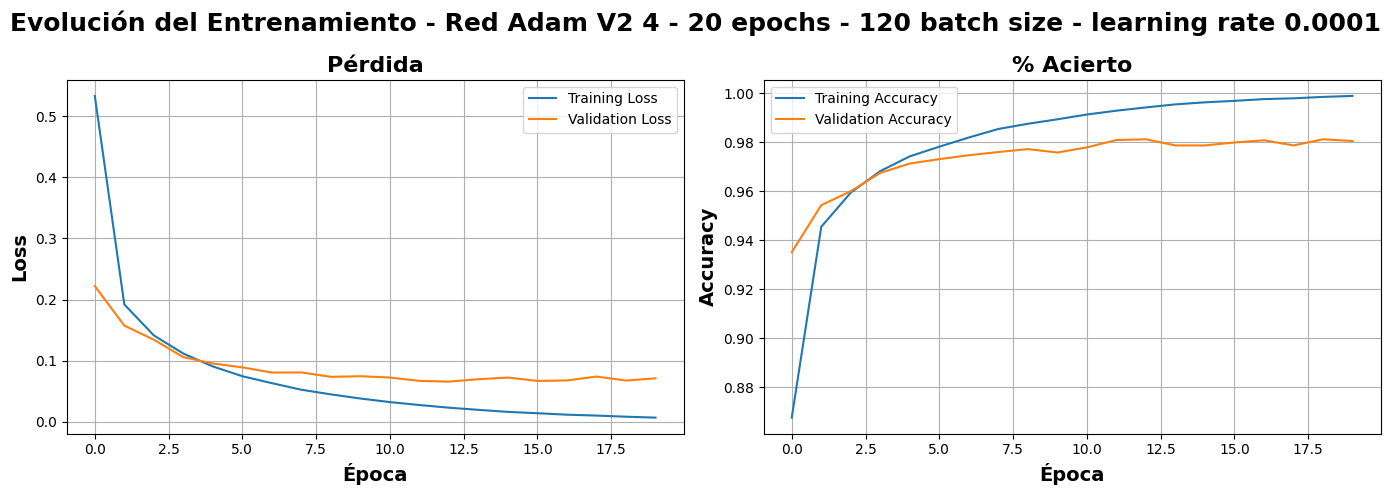

In [151]:
# graficamos la red
plot_history(hist_red_adamv2_4, name_model='Red Adam V2 4 - 20 epochs - 120 batch size - learning rate 0.0001')

In [152]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.0001,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': None,
    'train_loss': hist_red_adamv2_4.history['loss'][-1],
    'train_accuracy': hist_red_adamv2_4.history['accuracy'][-1],
    'test_loss': hist_red_adamv2_4.history['val_loss'][-1],
    'test_accuracy': hist_red_adamv2_4.history['val_accuracy'][-1]
})
columnas.append(nombre_red)

## Resultados Experimentacion 2: Cambios en Learning Rate

Se puede apreciar que los cambios en learning rate afectan de manera significativa en el entrenamiento de modelos de redes neuronales. Podemos observar que el modelo con learning rate con valor de 0.1 tiene una performance muy mala, en comparacion con 0.01 y 0.001 en ambos con un rendimiento similar. El learning rate con el que nuestro modelo funciona de mejor manera es el por default, cuyo valor es 0.001.


## Experimentación 3: Cambios en dropout y activadores

- Drop out: Técnica de regularización que apaga aleatoriamente un porcentaje de neuronas durante el entrenamiento para evitar overfitting.
- Activadores: Funciones que introducen no linealidad a la red, permitiendo aprender patrones complejos.

En este caso veremos que sucede con la implementación de dropout, con activadores relu y leaky relu, observando como cambia el rendimiento del modelo de redes neuronales con distintas configuraciones.

### 1. Drop out + relu + softmax 

In [134]:
neuronas=[512, 256, 128]

activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V3_1"
dropout = [0.2, 0.3, 0.1]  # Tasa de dropout por capa 

## Crear red
red_adamv3_1 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=dropout,
    nombre=nombre_red
)

In [82]:
## Compilacion de la red para resetear pesos
red_adamv3_1.compile(
    loss= 'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

## Entrenamiento de la red
hist_red_adamv3_1 = red_adamv3_1.fit(
        X_train, y_train,
        epochs=20,
        batch_size=120,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8335 - loss: 0.5304 - val_accuracy: 0.9573 - val_loss: 0.1641
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9362 - loss: 0.2459 - val_accuracy: 0.9558 - val_loss: 0.1917
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9422 - loss: 0.2350 - val_accuracy: 0.9595 - val_loss: 0.1589
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9437 - loss: 0.2314 - val_accuracy: 0.9633 - val_loss: 0.1528
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9449 - loss: 0.2290 - val_accuracy: 0.9664 - val_loss: 0.1353
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9493 - loss: 0.2036 - val_accuracy: 0.9624 - val_loss: 0.1455
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9509 - loss: 0.2107 - val_accuracy: 0.9650 - val_loss: 0.1487
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9470 - loss: 0.2268 - val_accuracy: 0.

In [135]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.01,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': dropout,
    'train_loss': hist_red_adamv3_1.history['loss'][-1],
    'train_accuracy': hist_red_adamv3_1.history['accuracy'][-1],
    'test_loss': hist_red_adamv3_1.history['val_loss'][-1],
    'test_accuracy': hist_red_adamv3_1.history['val_accuracy'][-1]
})

columnas.append(nombre_red)

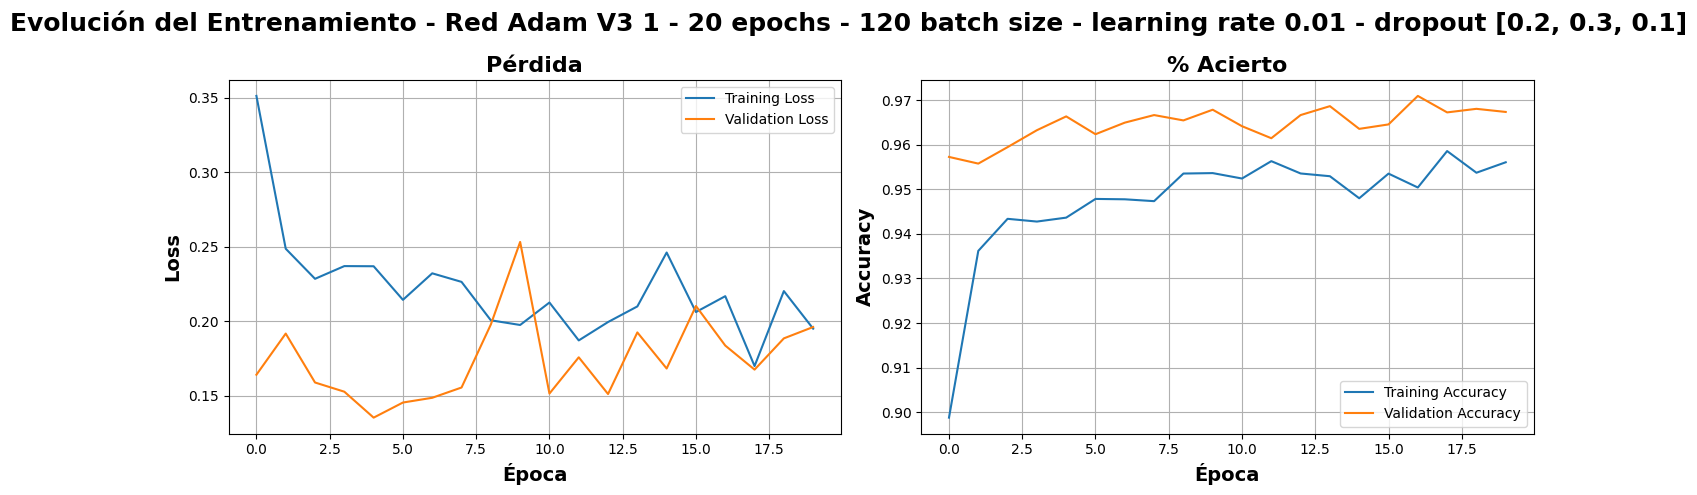

In [84]:
# graficamos el rendimiento de la red
plot_history(hist_red_adamv3_1, name_model='Red Adam V3 1 - 20 epochs - 120 batch size - learning rate 0.01 - dropout [0.2, 0.3, 0.1]')

### 2. Drop out + Leaky Relu + softmax 

In [136]:
neuronas=[512, 256, 128]

activaciones = ['leaky_relu', 'leaky_relu', 'leaky_relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V3_2"
dropout = [0.2, 0.3, 0.1]  # Tasa de dropout por capa 

## Crear red
red_adamv3_2 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=dropout,
    nombre=nombre_red
)

In [86]:
## Compilacion de la red para resetear pesos
red_adamv3_2.compile(
    loss= 'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

## Entrenamiento de la red
hist_red_adamv3_2 = red_adamv3_2.fit(
        X_train, y_train,
        epochs=20,
        batch_size=120,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8080 - loss: 0.7022 - val_accuracy: 0.9294 - val_loss: 0.2530
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8835 - loss: 0.5502 - val_accuracy: 0.8889 - val_loss: 0.9768
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8674 - loss: 1.2334 - val_accuracy: 0.9361 - val_loss: 0.4159
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9118 - loss: 0.5427 - val_accuracy: 0.9401 - val_loss: 0.3120
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9294 - loss: 0.3732 - val_accuracy: 0.8467 - val_loss: 2.0952
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8546 - loss: 8.5053 - val_accuracy: 0.9464 - val_loss: 0.7228
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9279 - loss: 0.9067 - val_accuracy: 0.9358 - val_loss: 0.4263
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9394 - loss: 0.4815 - val_accuracy: 0.

In [137]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.01,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': dropout,
    'train_loss': hist_red_adamv3_2.history['loss'][-1],
    'train_accuracy': hist_red_adamv3_2.history['accuracy'][-1],
    'test_loss': hist_red_adamv3_2.history['val_loss'][-1],
    'test_accuracy': hist_red_adamv3_2.history['val_accuracy'][-1]
})

columnas.append(nombre_red)

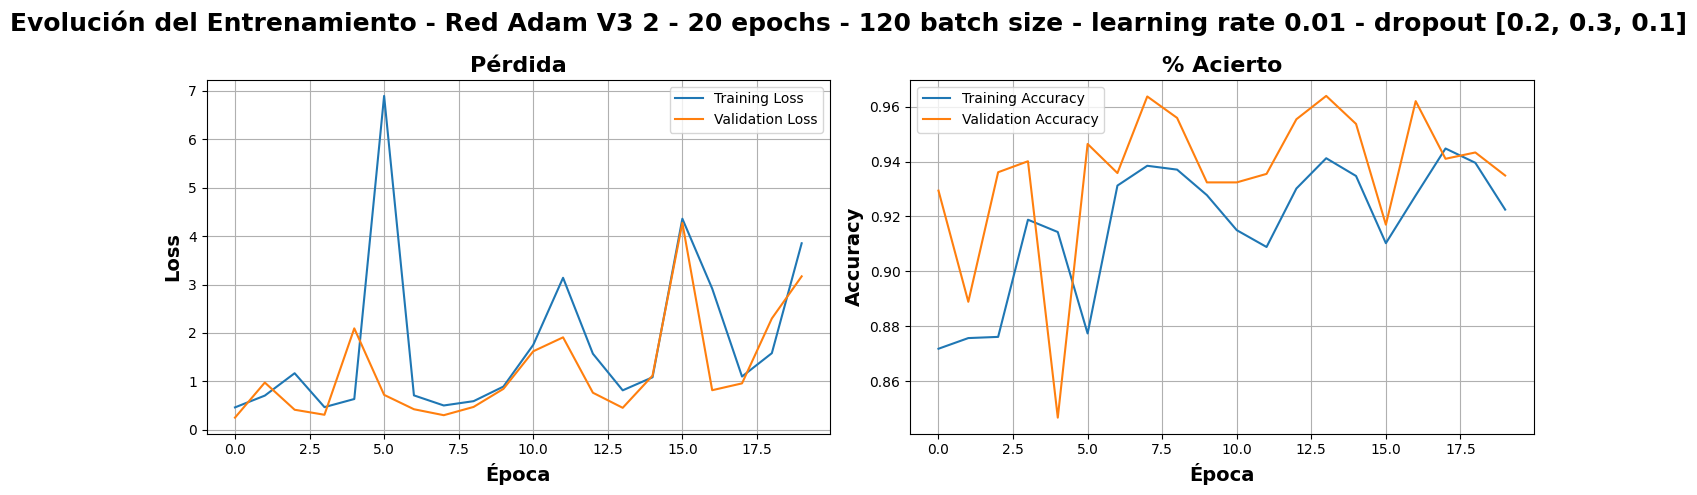

In [88]:
# graficamos el rendimiento de la red
plot_history(hist_red_adamv3_2, name_model='Red Adam V3 2 - 20 epochs - 120 batch size - learning rate 0.01 - dropout [0.2, 0.3, 0.1]')

### 3. Drop out Mayor + Leaky Relu + softmax 

In [166]:
neuronas=[512, 256, 128]

activaciones = ['leaky_relu', 'leaky_relu', 'leaky_relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V3_3"
dropout = [0.5, 0.3, 0.3]  # Tasa de dropout por capa 

## Crear red
red_adamv3_3 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=dropout,
    nombre=nombre_red
)

In [167]:
## Compilacion de la red para resetear pesos
red_adamv3_3.compile(
    loss= 'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

## Entrenamiento de la red
hist_red_adamv3_3 = red_adamv3_3.fit(
        X_train, y_train,
        epochs=20,
        batch_size=120,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7708 - loss: 0.8161 - val_accuracy: 0.8943 - val_loss: 0.4945
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8043 - loss: 1.8426 - val_accuracy: 0.8897 - val_loss: 0.9959
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8440 - loss: 1.6522 - val_accuracy: 0.9273 - val_loss: 0.3441
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8807 - loss: 0.7030 - val_accuracy: 0.9271 - val_loss: 0.3781
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8501 - loss: 1.9360 - val_accuracy: 0.8415 - val_loss: 10.2958
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8243 - loss: 11.2467 - val_accuracy: 0.9300 - val_loss: 1.1208
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8729 - loss: 2.2463 - val_accuracy: 0.9442 - val_loss: 0.5586
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8911 - loss: 1.3592 - val_accuracy: 

In [168]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.01,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': dropout,
    'train_loss': hist_red_adamv3_3.history['loss'][-1],
    'train_accuracy': hist_red_adamv3_3.history['accuracy'][-1],
    'test_loss': hist_red_adamv3_3.history['val_loss'][-1],
    'test_accuracy': hist_red_adamv3_3.history['val_accuracy'][-1]
})

columnas.append(nombre_red)

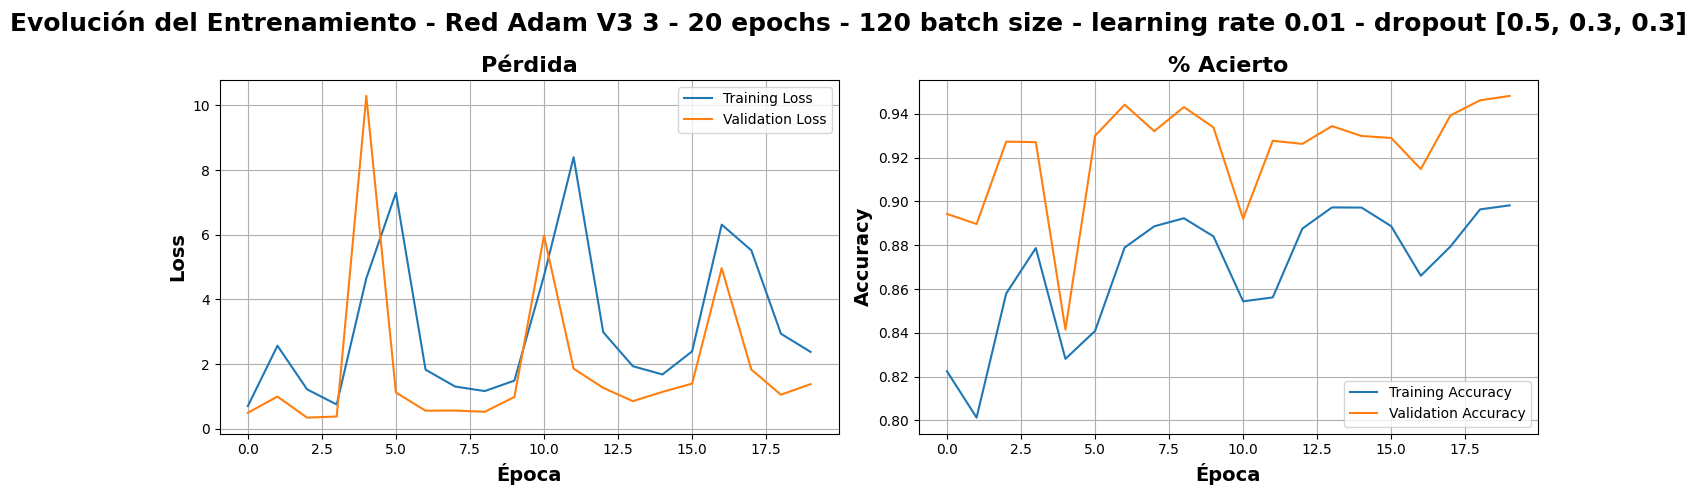

In [174]:
plot_history(hist_red_adamv3_3, name_model='Red Adam V3 3 - 20 epochs - 120 batch size - learning rate 0.01 - dropout [0.5, 0.3, 0.3] ')

### Observaciones
Segun lo estudiado y analisando previamente, se preveía que el modelo tuviera un buen rendimiento convinando leaky relu como activador de las capas internas y dropout en cada una de ellas. Sin embargo se obserba en los resultados que el rendimiento baja levemente cuando se utilizan dichas técnicas.

## Evaluación de los modelos con optimizador Adam

In [169]:
redes_df = pd.DataFrame(history_reds, index=range(1, len(history_reds) + 1)).T


redes_df.columns = columnas

redes_df = redes_df.T

redes_df

,epocas,batch_size,learning_rate,activadores,loss_function,dropout,train_loss,train_accuracy,test_loss,test_accuracy
Red_Neuronal_Adam_V1,30,20,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.011239,0.9976,0.165075,0.9825
Red_Neuronal_Adam_V1_2,30,60,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.00715,0.997833,0.110581,0.9811
Red_Neuronal_Adam_V1_3,20,120,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.007814,0.997717,0.088835,0.9832
Red_Neuronal_Adam_V2_1,20,120,0.1,"[relu, relu, relu, softmax]",categorical_crossentropy,None,2.307915,0.105433,2.311269,0.0974
Red_Neuronal_Adam_V2_2,20,120,0.01,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.051119,0.988667,0.162312,0.9716
Red_Neuronal_Adam_V2_3,20,120,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.007814,0.997717,0.088835,0.9832
Red_Neuronal_Adam_V3_1,20,120,0.01,"[relu, relu, relu, softmax]",categorical_crossentropy,"[0.2, 0.3, 0.1]",0.195045,0.9561,0.196153,0.9674
Red_Neuronal_Adam_V3_2,20,120,0.01,"[leaky_relu, leaky_relu, leaky_relu, softmax]",categorical_crossentropy,"[0.2, 0.3, 0.1]",3.851232,0.922483,3.168671,0.9349
Red_Neuronal_Adam_V2_4,20,120,0.0001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.006731,0.998917,0.071119,0.9805
Red_Neuronal_Adam_V3_3,20,120,0.01,"[leaky_relu, leaky_relu, leaky_relu, softmax]",categorical_crossentropy,"[0.4, 0.2, 0.2]",3.851232,0.922483,3.168671,0.9349


In [170]:
# ordenar lista por mejor performance en testeo
redes_df = redes_df.sort_values(by='test_accuracy', ascending=False)
redes_df

,epocas,batch_size,learning_rate,activadores,loss_function,dropout,train_loss,train_accuracy,test_loss,test_accuracy
Red_Neuronal_Adam_V1_3,20,120,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.007814,0.997717,0.088835,0.9832
Red_Neuronal_Adam_V2_3,20,120,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.007814,0.997717,0.088835,0.9832
Red_Neuronal_Adam_V1,30,20,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.011239,0.9976,0.165075,0.9825
Red_Neuronal_Adam_V1_2,30,60,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.00715,0.997833,0.110581,0.9811
Red_Neuronal_Adam_V2_4,20,120,0.0001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.006731,0.998917,0.071119,0.9805
Red_Neuronal_Adam_V2_2,20,120,0.01,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.051119,0.988667,0.162312,0.9716
Red_Neuronal_Adam_V3_1,20,120,0.01,"[relu, relu, relu, softmax]",categorical_crossentropy,"[0.2, 0.3, 0.1]",0.195045,0.9561,0.196153,0.9674
Red_Neuronal_Adam_V3_3,20,120,0.01,"[leaky_relu, leaky_relu, leaky_relu, softmax]",categorical_crossentropy,"[0.4, 0.2, 0.2]",5.070409,0.898,1.732203,0.9508
Red_Neuronal_Adam_V3_3,20,120,0.01,"[leaky_relu, leaky_relu, leaky_relu, softmax]",categorical_crossentropy,"[0.5, 0.3, 0.3]",2.377723,0.898217,1.378883,0.9482
Red_Neuronal_Adam_V3_2,20,120,0.01,"[leaky_relu, leaky_relu, leaky_relu, softmax]",categorical_crossentropy,"[0.2, 0.3, 0.1]",3.851232,0.922483,3.168671,0.9349


### Matriz de confusion del mejor modelo

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


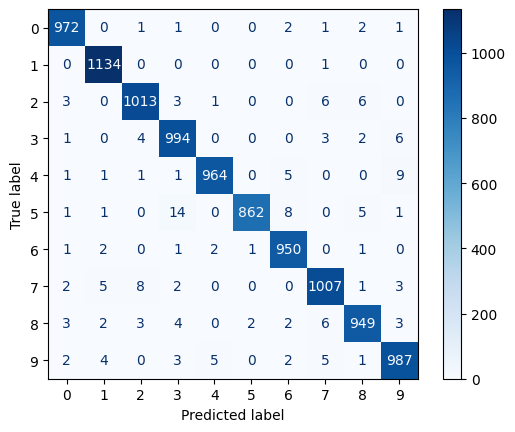

In [176]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. Obtener las predicciones del modelo
y_pred_prob = red_adamv1_3.predict(X_test)

# 2. Convertir las probabilidades a etiquetas (si es clasificación multiclase)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)  # si y_test está one-hot encoded

# 3. Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 4. Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

### Otras metricas de interes

In [177]:
from sklearn.metrics import classification_report

# 1. Predecir probabilidades con el modelo
y_pred_prob = red_adamv1_3.predict(X_test)

# 2. Obtener clases predichas (índice de mayor probabilidad)
y_pred = np.argmax(y_pred_prob, axis=1)

# 3. Obtener clases verdaderas (si están one-hot encoded)
y_true = np.argmax(y_test, axis=1)

# 4. Calcular métricas
report = classification_report(y_true, y_pred, digits=4)
print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0     0.9858    0.9918    0.9888       980
           1     0.9869    0.9991    0.9930      1135
           2     0.9835    0.9816    0.9825      1032
           3     0.9717    0.9842    0.9779      1010
           4     0.9918    0.9817    0.9867       982
           5     0.9965    0.9664    0.9812       892
           6     0.9804    0.9916    0.9860       958
           7     0.9786    0.9796    0.9791      1028
           8     0.9814    0.9743    0.9778       974
           9     0.9772    0.9782    0.9777      1009

    accuracy                         0.9832     10000
   macro avg     0.9834    0.9828    0.9831     10000
weighted avg     0.9833    0.9832    0.9832     10000



## Resultados finales de los modelos con optimizador Adam

El modelo **Red_Neuronal_Adam_V1_3** es el más balanceado y efectivo de todos los evaluados, ya que logra una alta precisión tanto en el conjunto de entrenamiento como en el de prueba, y mantiene pérdidas bajas, lo que indica una buena capacidad de generalización sin sobreajuste. Esto lo convierte en la mejor opción entre las arquitecturas probadas con el optimizador Adam.

### Guardar modelo y pesos

In [171]:
red_adamv1_3.save("red_adamv1_3.h5")
red_adamv1_3.save_weights("pesos_red_adamv1_3.weights.h5")

# Optimizador 2: SGD

### Modelo 1
sgd, relu, softmax, categorical_crossentropy

In [ ]:
h1 = 512
h2 = 256
h3 = 128

red_sgd = keras.Sequential(name="Red_Neuronal_sgd")
red_sgd.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd.add(keras.layers.Dense(h1, activation='relu'))
red_sgd.add(keras.layers.Dense(h2, activation='relu'))
red_sgd.add(keras.layers.Dense(h3, activation='relu'))
red_sgd.add(keras.layers.Dense(C, activation='softmax'))

red_sgd.summary()

red_sgd.compile(
    loss= 'categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Model: "Red_Neuronal_sgd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo 2
 sgd, relu, softmax, categorical_crossentropy y learning rate

In [ ]:
h1 = 512
h2 = 256
h3 = 128

red_sgd_lr = keras.Sequential(name="Red_Neuronal_sgd")
red_sgd_lr.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_lr.add(keras.layers.Dense(h1, activation='relu'))
red_sgd_lr.add(keras.layers.Dense(h2, activation='relu'))
red_sgd_lr.add(keras.layers.Dense(h3, activation='relu'))
red_sgd_lr.add(keras.layers.Dense(C, activation='softmax'))

red_sgd_lr.summary()

red_sgd_lr.compile(
    loss= 'categorical_crossentropy',
    optimizer=SGD(learning_rate=0.1),
    metrics=['accuracy']
)

Model: "Red_Neuronal_sgd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_73 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo 3
sgd, relu, softmax, binary_crossentropy

In [ ]:
h1 = 512
h2 = 256
h3 = 128

red_sgd_binary_soft = keras.Sequential(name="Red_Neuronal_sgd")
red_sgd_binary_soft.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_binary_soft.add(keras.layers.Dense(h1, activation='relu'))
red_sgd_binary_soft.add(keras.layers.Dense(h2, activation='relu'))
red_sgd_binary_soft.add(keras.layers.Dense(h3, activation='relu'))
red_sgd_binary_soft.add(keras.layers.Dense(C, activation='softmax'))

red_sgd_binary_soft.summary()

red_sgd_binary_soft.compile(
    loss= 'binary_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Model: "Red_Neuronal_sgd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_77 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo 4
sgd, relu, sigmoid, categorical_crossentropy

In [ ]:
h1 = 512
h2 = 256
h3 = 128

red_sgd_sigmoid_cat = keras.Sequential(name="Red_Neuronal_sgd")
red_sgd_sigmoid_cat.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_sigmoid_cat.add(keras.layers.Dense(h1, activation='relu'))
red_sgd_sigmoid_cat.add(keras.layers.Dense(h2, activation='relu'))
red_sgd_sigmoid_cat.add(keras.layers.Dense(h3, activation='relu'))
red_sgd_sigmoid_cat.add(keras.layers.Dense(C, activation='sigmoid'))

red_sgd_sigmoid_cat.summary()

red_sgd_sigmoid_cat.compile(
    loss= 'categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Model: "Red_Neuronal_sgd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_81 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo 5
sgd, relu, softmax, categorical_crossentropy y **dropout**

In [ ]:
h1 = 512
h2 = 256
h3 = 128

red_dropout = keras.Sequential(name="Red_Neuronal_sgd_dropout")
red_dropout.add(keras.layers.Input(shape=(N,), name='entrada'))
red_dropout.add(keras.layers.Dense(h1, activation='relu'))
red_dropout.add(keras.layers.Dense(h2, activation='relu'))
red_dropout.add(keras.layers.Dropout(0.3))
red_dropout.add(keras.layers.Dense(h3, activation='relu'))
red_dropout.add(keras.layers.Dropout(0.1))
red_dropout.add(keras.layers.Dense(C, activation='softmax'))

red_dropout.summary()

red_dropout.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Model: "Red_Neuronal_sgd_dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo 6
sgd, relu, softmax, categorical_crossentropy, dropout y learning rate

In [ ]:
h1 = 512
h2 = 256
h3 = 128

red_dropout_lr = keras.Sequential(name="Red_Neuronal_sgd_dropout")
red_dropout_lr.add(keras.layers.Input(shape=(N,), name='entrada'))
red_dropout_lr.add(keras.layers.Dense(h1, activation='relu'))
red_dropout_lr.add(keras.layers.Dense(h2, activation='relu'))
red_dropout_lr.add(keras.layers.Dropout(0.3))
red_dropout_lr.add(keras.layers.Dense(h3, activation='relu'))
red_dropout_lr.add(keras.layers.Dropout(0.1))
red_dropout_lr.add(keras.layers.Dense(C, activation='softmax'))

red_dropout_lr.summary()

red_dropout_lr.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.1),
    metrics=['accuracy']
)

Model: "Red_Neuronal_sgd_dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_89 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo 7
sgd, tanh, softmax, categorial_crossentropy

In [ ]:
h1 = 512
h2 = 256
h3 = 128

red_sgd_sigmoid = keras.Sequential(name="Red_Neuronal_sgd")
red_sgd_sigmoid.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_sigmoid.add(keras.layers.Dense(h1, activation='tanh'))
red_sgd_sigmoid.add(keras.layers.Dense(h2, activation='tanh'))
red_sgd_sigmoid.add(keras.layers.Dense(h3, activation='tanh'))
red_sgd_sigmoid.add(keras.layers.Dense(C, activation='softmax'))

red_sgd_sigmoid.summary()

red_sgd_sigmoid.compile(
    loss= 'categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Model: "Red_Neuronal_sgd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_93 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo 8
sgd, tanh, sigmoid, categorial_crossentropy y learning rate

In [ ]:
h1 = 512
h2 = 256
h3 = 128

red_sgd_sigmoid_lr = keras.Sequential(name="Red_Neuronal_sgd")
red_sgd_sigmoid_lr.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_sigmoid_lr.add(keras.layers.Dense(h1, activation='tanh'))
red_sgd_sigmoid_lr.add(keras.layers.Dense(h2, activation='tanh'))
red_sgd_sigmoid_lr.add(keras.layers.Dense(h3, activation='tanh'))
red_sgd_sigmoid_lr.add(keras.layers.Dense(C, activation='sigmoid'))

red_sgd_sigmoid_lr.summary()

red_sgd_sigmoid_lr.compile(
    loss= 'categorical_crossentropy',
    optimizer=SGD(learning_rate=0.1),
    metrics=['accuracy']
)

Model: "Red_Neuronal_sgd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_97 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo 9
sgd, tanh, sigmoid, binary_crossentropy

In [ ]:
h1 = 512
h2 = 256
h3 = 128

red_sgd_binary = keras.Sequential(name="Red_Neuronal_sgd_binary")
red_sgd_binary.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_binary.add(keras.layers.Dense(h1, activation='tanh'))
red_sgd_binary.add(keras.layers.Dense(h2, activation='tanh'))
red_sgd_binary.add(keras.layers.Dense(h3, activation='tanh'))
red_sgd_binary.add(keras.layers.Dense(C, activation='sigmoid'))

red_sgd_binary.summary()

red_sgd_binary.compile(
    loss='binary_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Model: "Red_Neuronal_sgd_binary"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_101 (Dense)               │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo 10
sgd, tanh, sigmoid, binary_crossentropy y learning rate

In [ ]:
h1 = 512
h2 = 256
h3 = 128

red_sgd_binary_lr = keras.Sequential(name="Red_Neuronal_sgd_binary")
red_sgd_binary_lr.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_binary_lr.add(keras.layers.Dense(h1, activation='tanh'))
red_sgd_binary_lr.add(keras.layers.Dense(h2, activation='tanh'))
red_sgd_binary_lr.add(keras.layers.Dense(h3, activation='tanh'))
red_sgd_binary_lr.add(keras.layers.Dense(C, activation='sigmoid'))

red_sgd_binary_lr.summary()

red_sgd_binary_lr.compile(
    loss='binary_crossentropy',
    optimizer=SGD(learning_rate=0.1),
    metrics=['accuracy']
)

Model: "Red_Neuronal_sgd_binary"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo 11
sgd, tanh, sigmoid, binary_crossentropy y dropout

In [ ]:
h1 = 512
h2 = 256
h3 = 128

red_sgd_binary_dropout = keras.Sequential(name="Red_Neuronal_sgd_binary")
red_sgd_binary_dropout.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_binary_dropout.add(keras.layers.Dense(h1, activation='tanh'))
red_sgd_binary_dropout.add(keras.layers.Dense(h2, activation='tanh'))
red_sgd_binary_dropout.add(keras.layers.Dropout(0.3))
red_sgd_binary_dropout.add(keras.layers.Dense(h3, activation='tanh'))
red_sgd_binary_dropout.add(keras.layers.Dropout(0.1))
red_sgd_binary_dropout.add(keras.layers.Dense(C, activation='sigmoid'))

red_sgd_binary_dropout.summary()

red_sgd_binary_dropout.compile(
    loss='binary_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Model: "Red_Neuronal_sgd_binary"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_109 (Dense)               │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo 12
sgd, tanh, sigmoid, binary_crossentropy, dropout y learning rate

In [ ]:
h1 = 512
h2 = 256
h3 = 128

red_sgd_binary_dropout_lr = keras.Sequential(name="Red_Neuronal_sgd_binary")
red_sgd_binary_dropout_lr.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_binary_dropout_lr.add(keras.layers.Dense(h1, activation='tanh'))
red_sgd_binary_dropout_lr.add(keras.layers.Dense(h2, activation='tanh'))
red_sgd_binary_dropout_lr.add(keras.layers.Dropout(0.3))
red_sgd_binary_dropout_lr.add(keras.layers.Dense(h3, activation='tanh'))
red_sgd_binary_dropout_lr.add(keras.layers.Dropout(0.1))
red_sgd_binary_dropout_lr.add(keras.layers.Dense(C, activation='sigmoid'))

red_sgd_binary_dropout_lr.summary()

red_sgd_binary_dropout_lr.compile(
    loss='binary_crossentropy',
    optimizer=SGD(learning_rate=0.1),
    metrics=['accuracy']
)

Model: "Red_Neuronal_sgd_binary"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_113 (Dense)               │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

Para todos estos modelo se aplicaron distintas funciones las cuales son:

*   Activación: ReLu y Sigmoid
*   Salida: Softmax y Sigmoid
*   Perdida: Categorical_crossentropy y Binary_crossentropy



In [ ]:
def plot_history(hist, name_model):

  # Crear figura con dos subplots horizontales
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  fig.suptitle(name_model, fontweight="bold", fontsize=18)

  # --- Pérdida ---
  axs[0].plot(hist.history['loss'], label='Training Loss')
  axs[0].plot(hist.history['val_loss'], label='Validation Loss')
  axs[0].set_title('Pérdida', fontweight="bold", fontsize=16)
  axs[0].set_xlabel('Época', fontweight="bold", fontsize=14)
  axs[0].set_ylabel('Loss', fontweight="bold", fontsize=14)
  axs[0].legend()
  axs[0].grid(True)

  # --- Precisión ---
  axs[1].plot(hist.history['accuracy'], label='Training Accuracy')
  axs[1].plot(hist.history['val_accuracy'], label='Validation Accuracy')
  axs[1].set_title('% Acierto', fontweight="bold", fontsize=16)
  axs[1].set_xlabel('Época', fontweight="bold", fontsize=14)
  axs[1].set_ylabel('Accuracy', fontweight="bold", fontsize=14)
  axs[1].legend()
  axs[1].grid(True)

  plt.tight_layout()
  plt.show()

## Entrenamiento

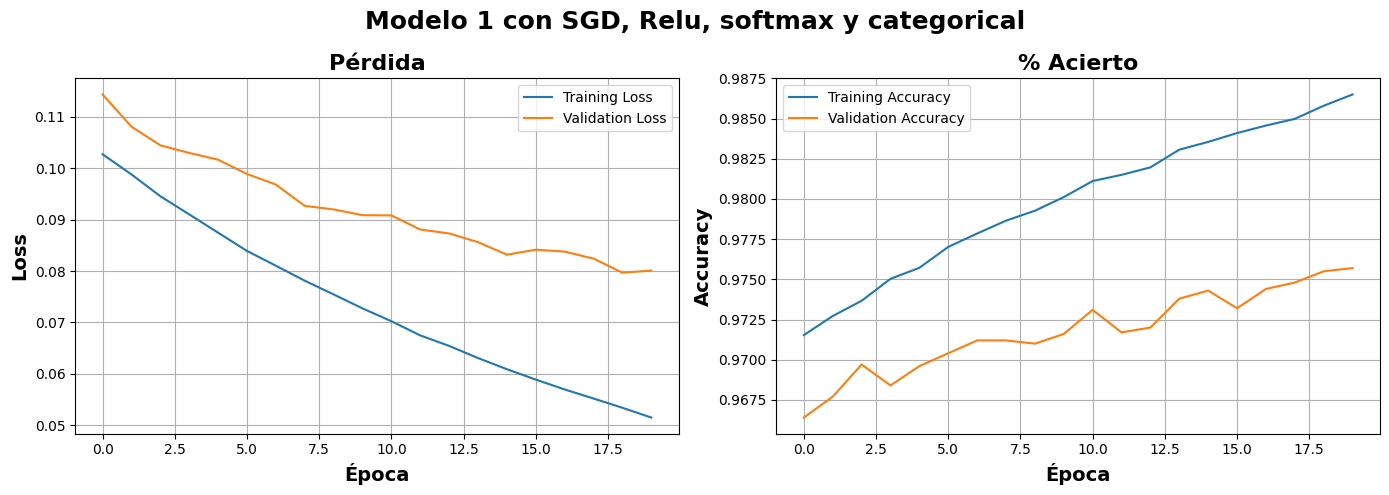

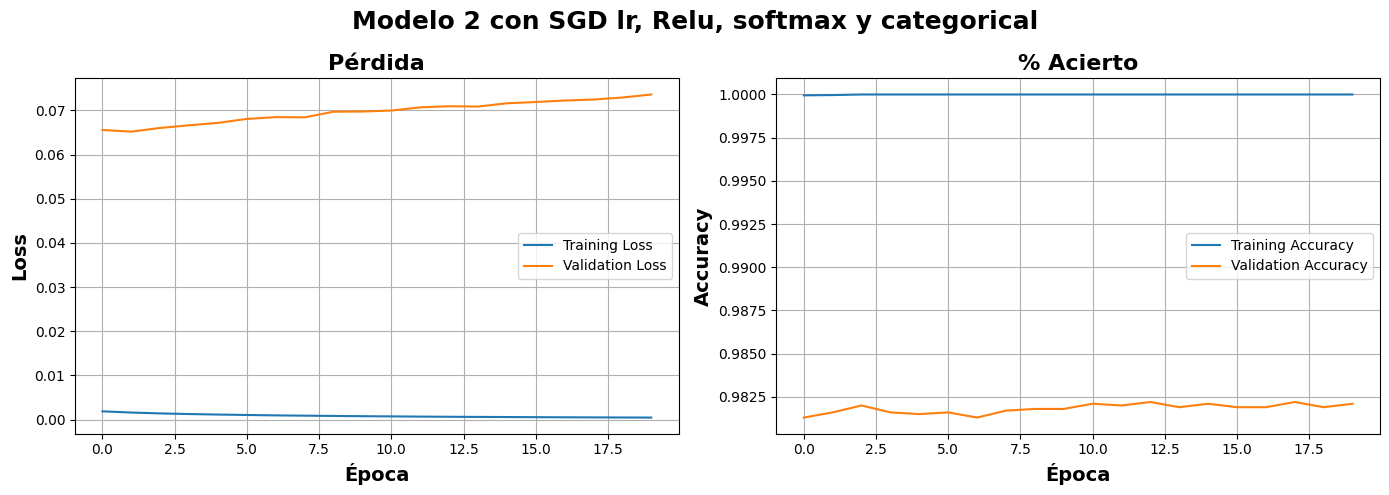

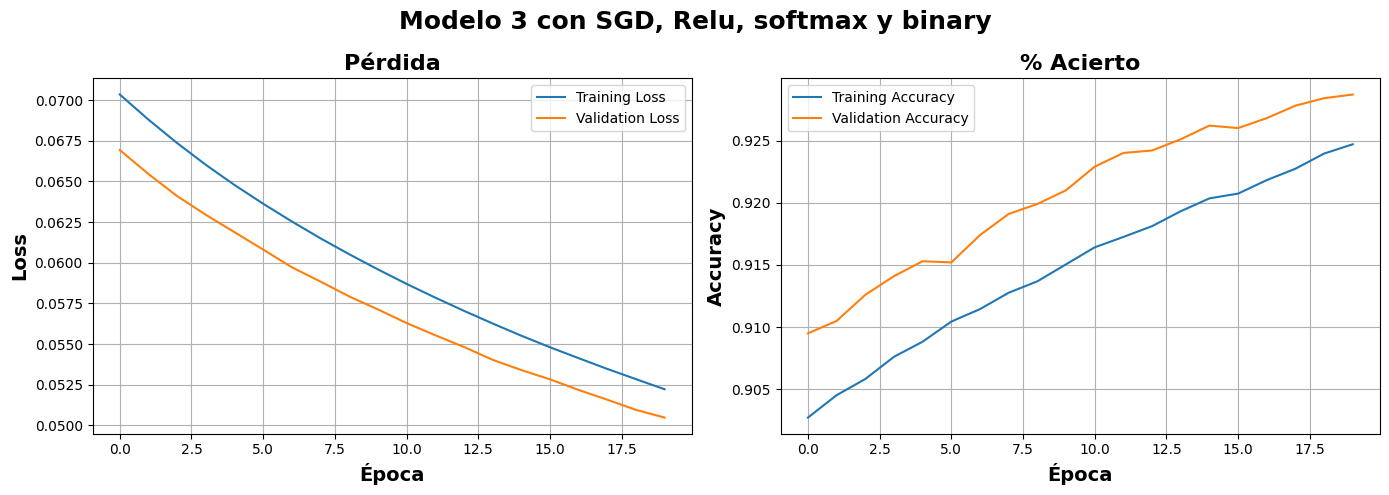

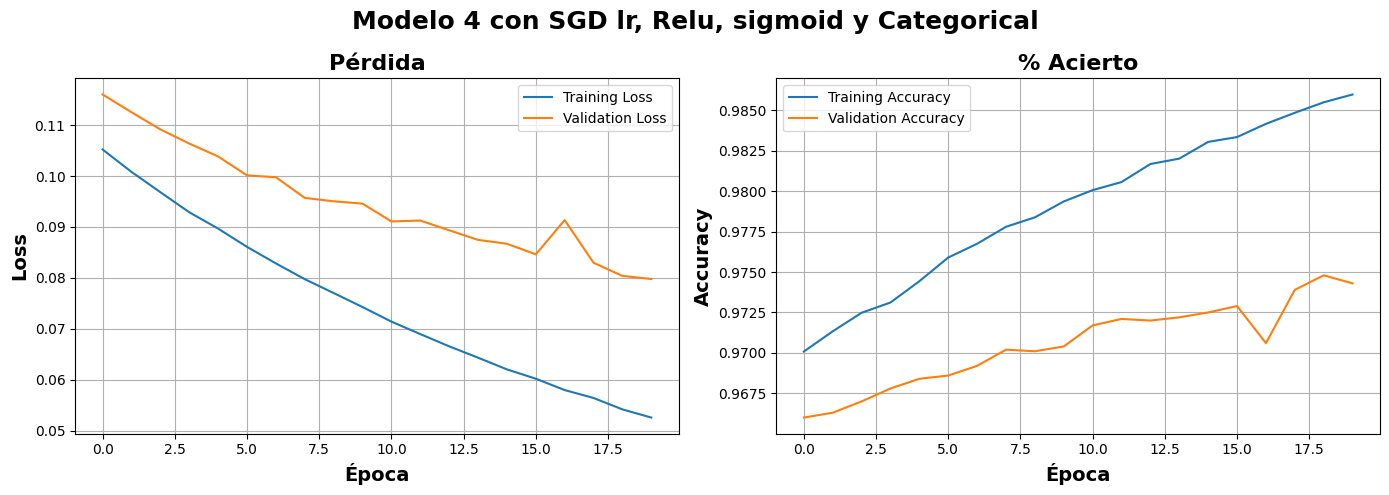

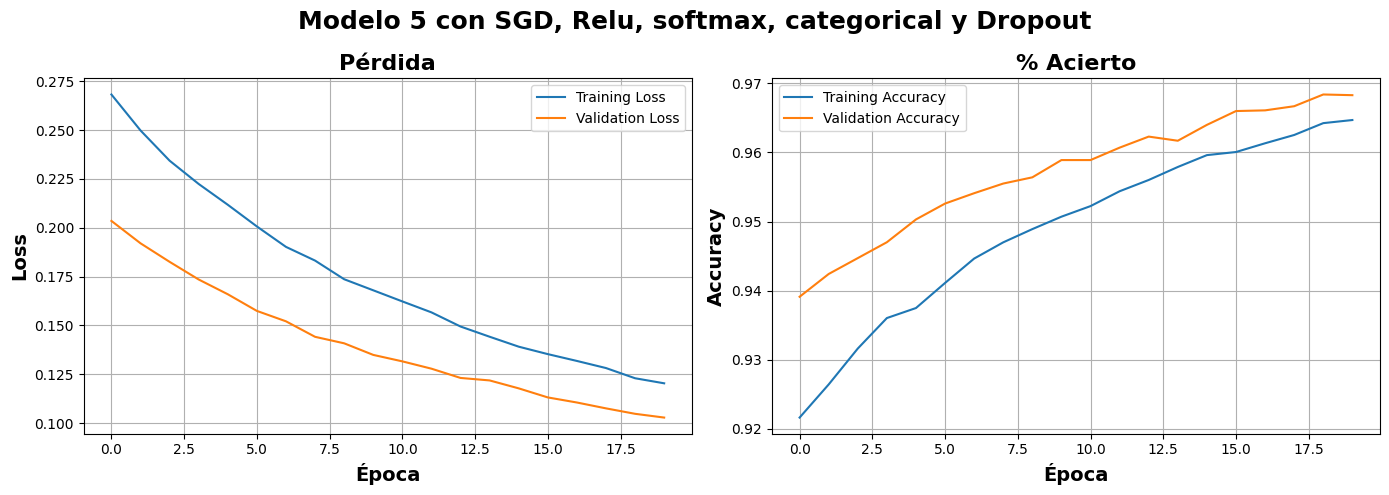

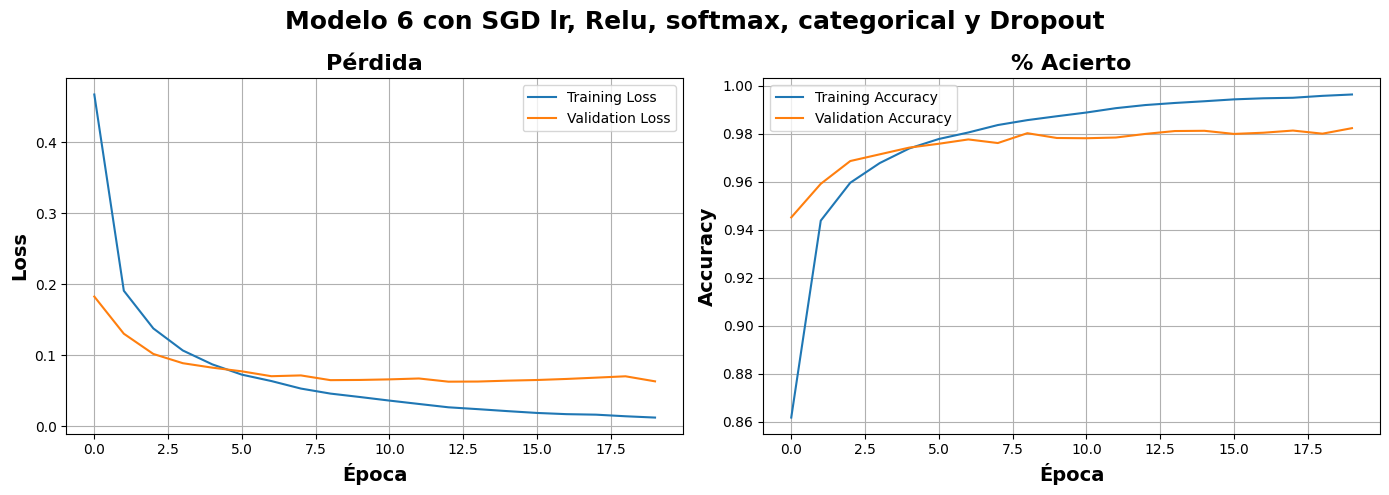

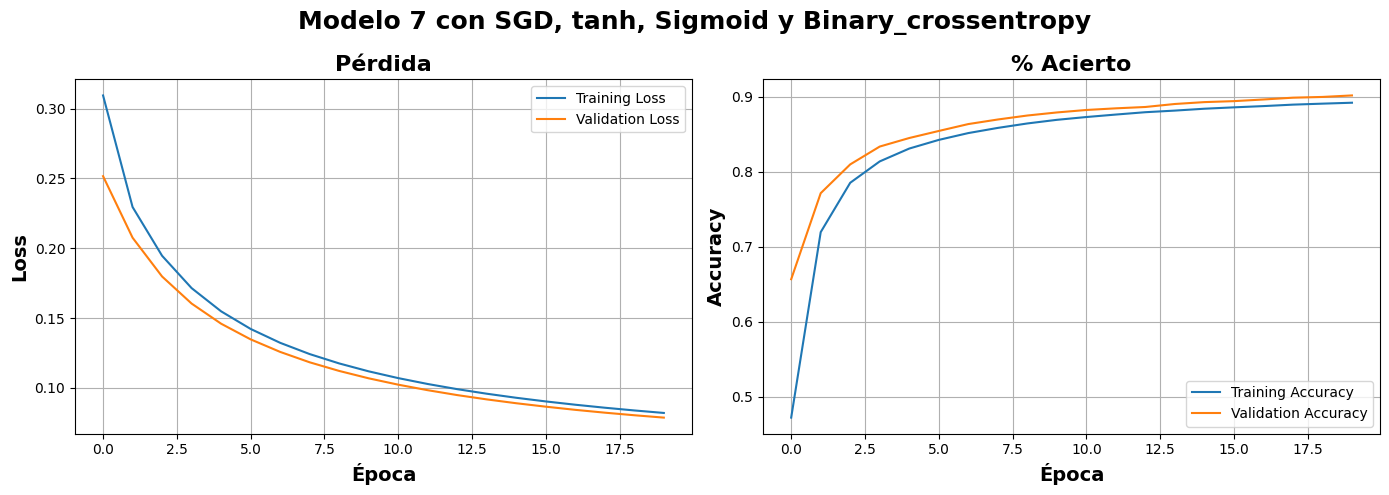

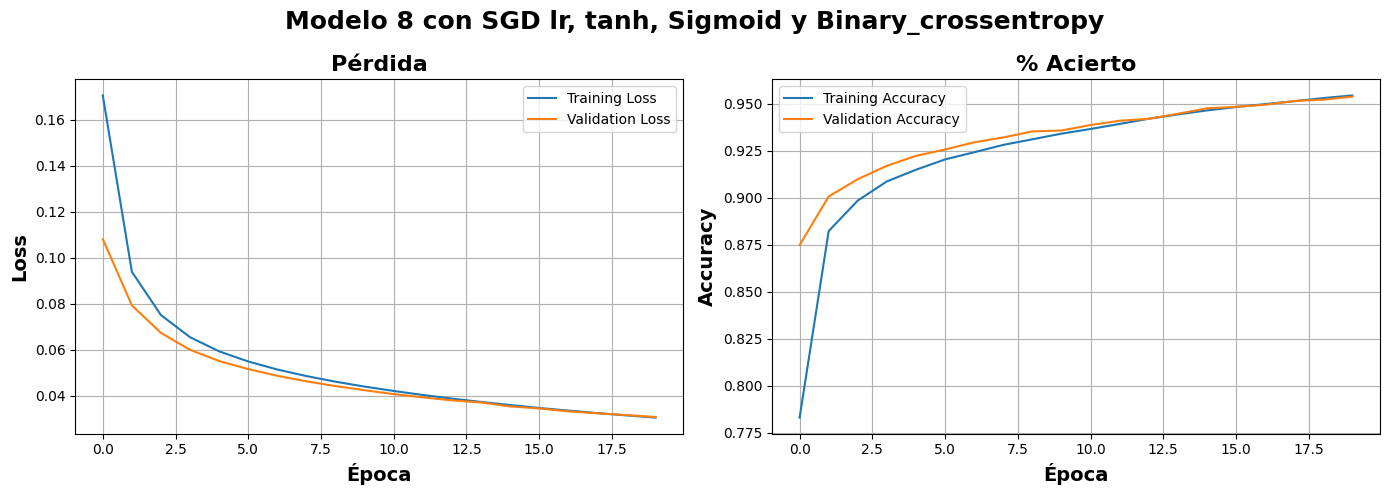

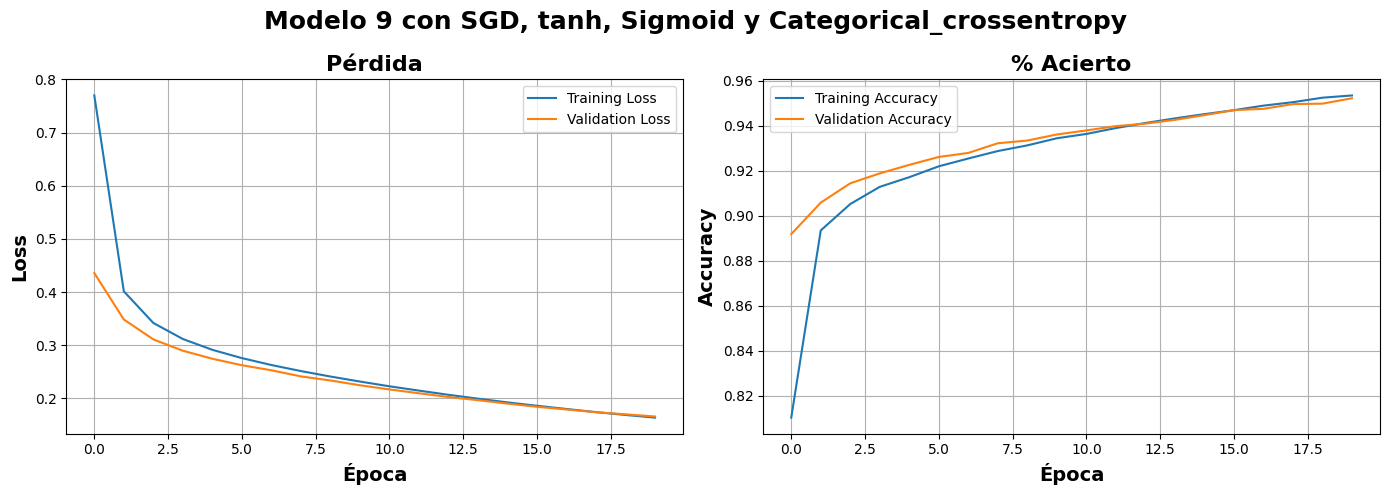

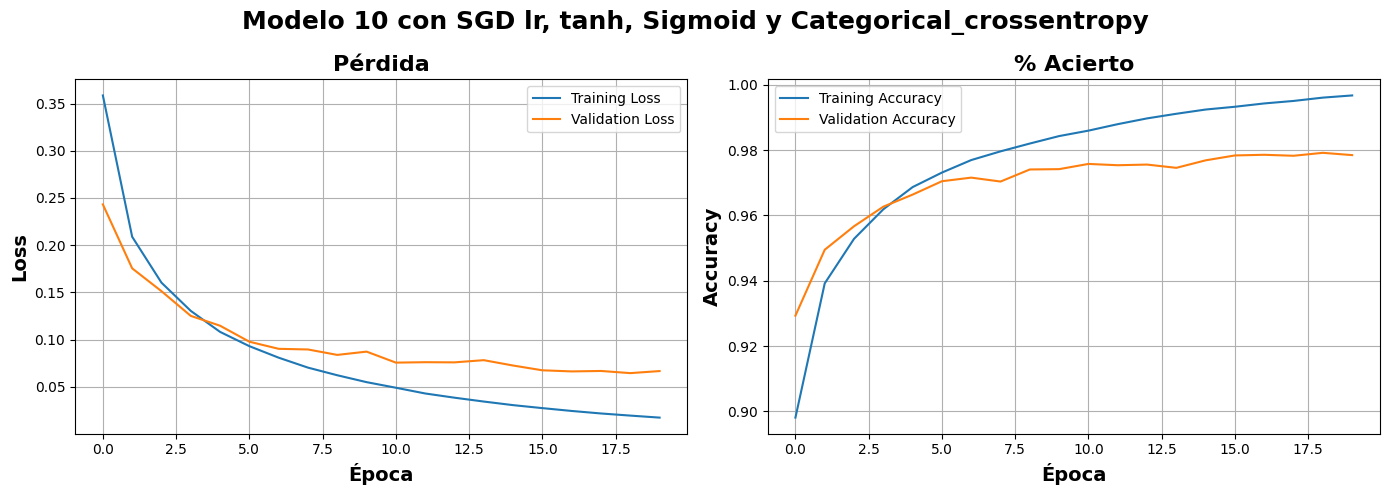

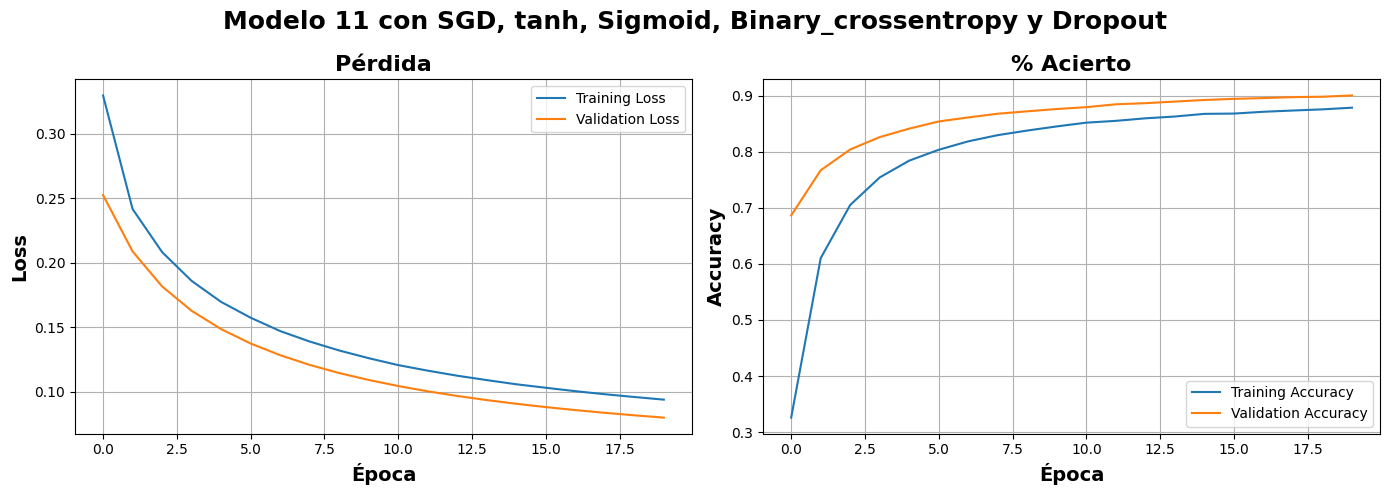

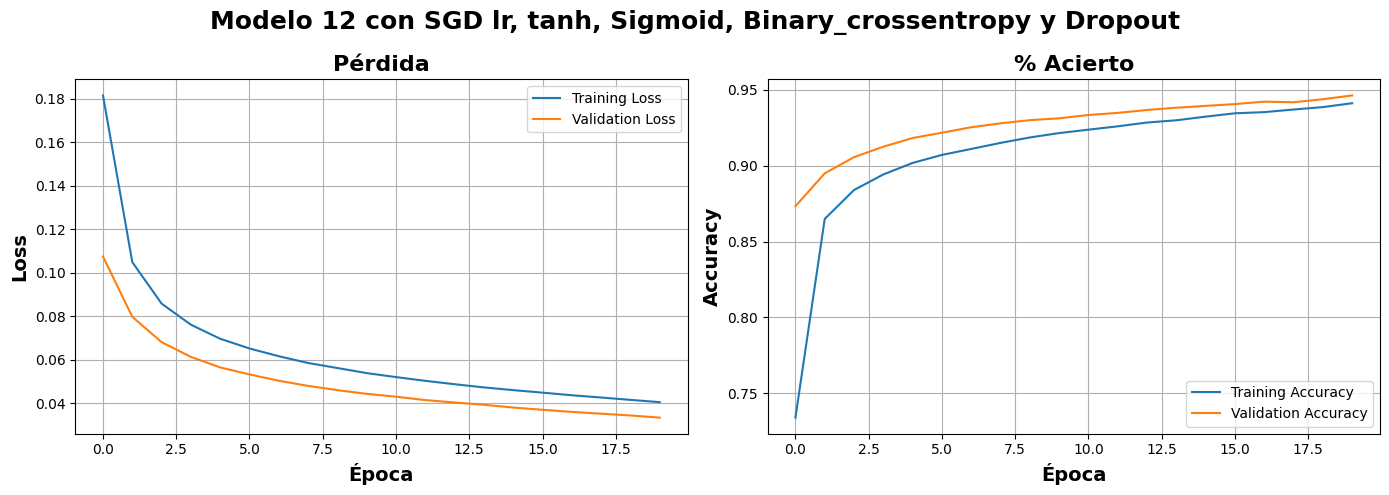

In [ ]:
resultados = []


modelos = [
    ('Modelo 1 con SGD, Relu, softmax y categorical', red_sgd), # Relu, Softmax, Categorical_crossentropy y SGD.
    ('Modelo 2 con SGD lr, Relu, softmax y categorical', red_sgd_lr), # Relu, Softmax, Categorical_crossentropy y SGD con Learning Rate.
    ('Modelo 3 con SGD, Relu, softmax y binary', red_sgd_binary_soft), # Relu, Softmax, Binary_crossentropy y SGD.
    ('Modelo 4 con SGD lr, Relu, sigmoid y Categorical', red_sgd_sigmoid_cat), # Relu, sigmoid, Categorical_crossentropy y SGD con Learning Rate.
    ('Modelo 5 con SGD, Relu, softmax, categorical y Dropout', red_dropout), # Relu, Softmax, Categorical_crossentropy, SGD y Dropout.
    ('Modelo 6 con SGD lr, Relu, softmax, categorical y Dropout', red_dropout_lr), # Relu, Softmax, Categorical_crossentropy, SGD con Learning Rate y Dropout.
    ('Modelo 7 con SGD, tanh, Sigmoid y Binary_crossentropy', red_sgd_binary), # tanh, Sigmoid, Binary_crossentropy y SGD.
    ('Modelo 8 con SGD lr, tanh, Sigmoid y Binary_crossentropy', red_sgd_binary_lr), # tanh, Sigmoid, Binary_crossentropy y SGD con Learning Rate.
    ('Modelo 9 con SGD, tanh, Sigmoid y Categorical_crossentropy', red_sgd_sigmoid), # tanh, Sigmoid, Categorical_crossentropy y SGD.
    ('Modelo 10 con SGD lr, tanh, Sigmoid y Categorical_crossentropy', red_sgd_sigmoid_lr), # tanh, Sigmoid, Categorical_crossentropy y SGD con Learning Rate.
    ('Modelo 11 con SGD, tanh, Sigmoid, Binary_crossentropy y Dropout', red_sgd_binary_dropout), # tanh, Sigmoid, Binary_crossentropy, SGD y Dropout.
    ('Modelo 12 con SGD lr, tanh, Sigmoid, Binary_crossentropy y Dropout', red_sgd_binary_dropout_lr), # tanh, Sigmoid, Binary_crossentropy, SGD con Learning Rate y Dropout.
]


for nombre_modelo, modelo in modelos:
    hist = modelo.fit(
        X_train, y_train,
        epochs=20,
        batch_size=128,
        validation_data=(X_test, y_test),
        verbose=0
    )

    plot_history(hist, nombre_modelo)

    print('\n')

    train_acc = hist.history['accuracy'][-1]
    val_acc = hist.history['val_accuracy'][-1]
    train_loss = hist.history['loss'][-1]
    val_loss = hist.history['val_loss'][-1]


    resultados.append({
        'Modelo': nombre_modelo,
        'Train Accuracy': train_acc,
        'Val Accuracy': val_acc,
        'Train Loss': train_loss,
        'Val Loss': val_loss
    })

df_resultados = pd.DataFrame(resultados)

## Resultados

In [ ]:
df_resultados.sort_values(by='Train Accuracy', ascending=False)

,Modelo,Train Accuracy,Val Accuracy,Train Loss,Val Loss
1,"Modelo 2 con SGD lr, Relu, softmax y categorical",1.000000,0.9821,0.000445,0.073616
9,"Modelo 10 con SGD lr, tanh, Sigmoid y Categori...",0.996783,0.9785,0.017452,0.066740
5,"Modelo 6 con SGD lr, Relu, softmax, categorica...",0.996433,0.9824,0.012484,0.063517
0,"Modelo 1 con SGD, Relu, softmax y categorical",0.986500,0.9757,0.051481,0.080077
3,"Modelo 4 con SGD lr, Relu, sigmoid y Categorical",0.985983,0.9743,0.052610,0.079797
4,"Modelo 5 con SGD, Relu, softmax, categorical y...",0.964700,0.9683,0.120404,0.102871
7,"Modelo 8 con SGD lr, tanh, Sigmoid y Binary_cr...",0.954450,0.9538,0.030609,0.030856
8,"Modelo 9 con SGD, tanh, Sigmoid y Categorical_...",0.953550,0.9523,0.163734,0.165797
11,"Modelo 12 con SGD lr, tanh, Sigmoid, Binary_cr...",0.941267,0.9464,0.040598,0.033498
2,"Modelo 3 con SGD, Relu, softmax y binary",0.924700,0.9287,0.052222,0.050482


Despues de haber compilado los modelos y entrenarlos, se obtienen los resultados. Para una visualización mas eficiente se ha guardado los resultados en una tabla para hacer comparaciones.  
Por lo general los modelos con el optimizados SGD obtienen buenos resultados los cuales no presentan una gran cantidad de overfitting.  
Si analizamos y comparamos el modelo 1 y 3 se obtiene la conclusión que la función de perdida es importante al momento de hacer el modelo, se establecio para el modelo 3 perdida el binary_crossentropy.  

Se debe mencionar la importancia del learning rate en los modelos, es tal la importancia de este hiperparametro que incrementan el rendimiento de los modelos al contrario de los que no tienen este hiperparametro definido de manera personalizada.  
Para lo modelos con la tecnica de Dropout implementada tienen peor rendimiento de los cuales no tienen, sin embargo aquellos modelos que tienen el dropout y el learning rate se incrementado su rendimiento. Mencionar que los valores determinados para el dropout son los siguientes: 0.3 para la 2da capa y 0.1 para la 3ra capa, esto pensado en la cantidad de neuronas de cada capa y la cantidad proporcional que se quiere apagar.

Para intepretación de la graficas de cada modelo, se evidencian dos lineas en cada grafico, estas lineas hacen la comparación del rendimiento del modelo en entrenamieto y validación.

De acuerdo a los gráficos la gran mayoría de los modelo empiezan con un rendimiento aceptable aunque después los modelos en general empieza a incrementar sus rendimiento y la perdida de cada unos de estos van disminuyendo.

In [ ]:
red_sgd_lr.save("red_neuronal_sgd.h5")
red_sgd_lr.save_weights("pesos_red_neuronal_sgd.weights.h5")